# **Load the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from ipywidgets import interact, IntSlider, Button, Layout
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import warnings
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
path = "/content/drive/MyDrive/IntelliHack/question4-stock-data.csv"
df= pd.read_csv(path)
df.columns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['Unnamed: 0', 'Date', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

In [ ]:
# Set visualization styles for more pleasing visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Custom color palette for better visualizations
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
sns.set_palette(sns.color_palette(colors))

# **Data Cleaning and preprocessing**

## Checks data types and missing values, removes unnecessary columns, handles missing dates, converts the Date column to datetime, sorts the dataset, and visualizes missing values.


In [ ]:
print("Dataset Information:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Shape: (11291, 8)

First 5 rows:
   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  


In [ ]:
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
Unnamed: 0      int64
Date           object
Adj Close     float64
Close         float64
High          float64
Low           float64
Open          float64
Volume        float64
dtype: object

Missing Values:
Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64


In [ ]:
# Handle 'Unnamed: 0' column - likely an index
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("\nRemoved 'Unnamed: 0' column")

# Handle missing values in 'Date' column
print(f"\nInitial date range with missing values: {pd.to_datetime(df['Date'].dropna()).min()} to {pd.to_datetime(df['Date'].dropna()).max()}")
date_nulls = df['Date'].isnull().sum()
print(f"Missing dates: {date_nulls}")


if date_nulls > 0:
    # Drop rows with missing dates as they cannot be properly imputed
    df = df[~df['Date'].isnull()]
    print(f"Dropped {date_nulls} rows with missing dates")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print("\nDataset with datetime index:")
print(df.head())

# Sort by date index
df = df.sort_index()
print("\nSorted by date:")
print(df.head())


Removed 'Unnamed: 0' column

Initial date range with missing values: 1980-03-17 00:00:00 to 2024-12-27 00:00:00
Missing dates: 110
Dropped 110 rows with missing dates

Dataset with datetime index:
            Adj Close     Close      High       Low      Open   Volume
Date                                                                  
1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000  41109.0
1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0
1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606      0.0
1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000  10277.0
1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   8409.0

Sorted by date:
            Adj Close     Close      High       Low      Open   Volume
Date                                                                  
1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000  41109.0
1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0
1980


Missing Value Percentages:
Adj Close    0.831768
Close        1.037474
High         0.849656
Low          1.126912
Open         0.894374
Volume       1.296843
dtype: float64


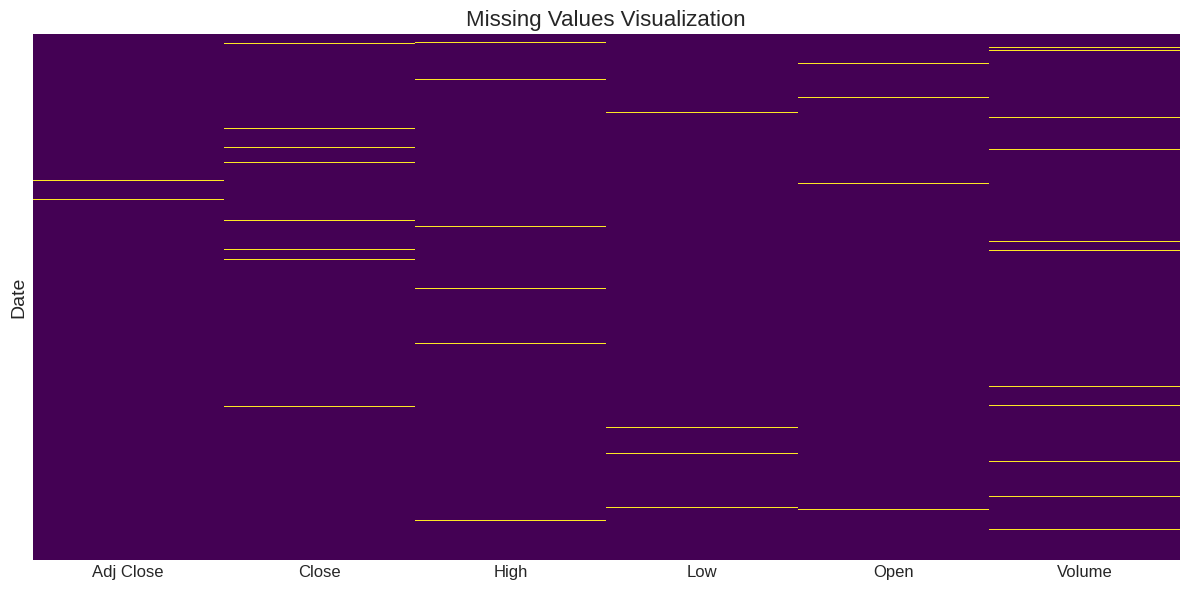

In [ ]:
# Missing value analysis
missing_percentage = df.isnull().sum() / len(df) * 100
print("\nMissing Value Percentages:")
print(missing_percentage)

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Visualization')
plt.tight_layout()
plt.savefig('missing_values_heatmap.png')
plt.show()

In [ ]:
# Handle missing values with forward fill (carrying last known value forward)
# This is appropriate for financial time series where we want to use the most recent available price
df_filled = df.fillna(method='ffill')
# For any remaining NaNs at the beginning of the dataset, use backfill
df_filled = df_filled.fillna(method='bfill')
print("\nRemaining missing values after imputation:")
print(df_filled.isnull().sum())

# Check for duplicates
duplicate_count = df_filled.index.duplicated().sum()
print(f"\nNumber of duplicate dates: {duplicate_count}")
if duplicate_count > 0:
    df_filled = df_filled[~df_filled.index.duplicated(keep='first')]
    print("Duplicates removed.")

# Basic statistics
print("\nSummary Statistics after cleaning:")
print(df_filled.describe())



Remaining missing values after imputation:
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Number of duplicate dates: 0

Summary Statistics after cleaning:
          Adj Close         Close          High           Low          Open  \
count  11181.000000  11181.000000  11181.000000  11181.000000  11181.000000   
mean      63.668077     72.126528     72.548109     71.712502     68.018510   
std       52.350679     51.362731     51.620587     51.043881     55.922053   
min        2.259452      3.237711      3.237711      3.237711      0.000000   
25%       19.224636     27.548208     27.735613     27.548208      0.000000   
50%       50.615738     66.062500     66.660004     65.470001     66.000000   
75%      104.843605    114.400002    114.980003    113.680000    114.500000   
max      254.770004    254.770004    255.229996    253.589996    255.000000   

             Volume  
count  1.118100e+04  
mean   2.149994e+05  
std    3.

# **Performing EDA**

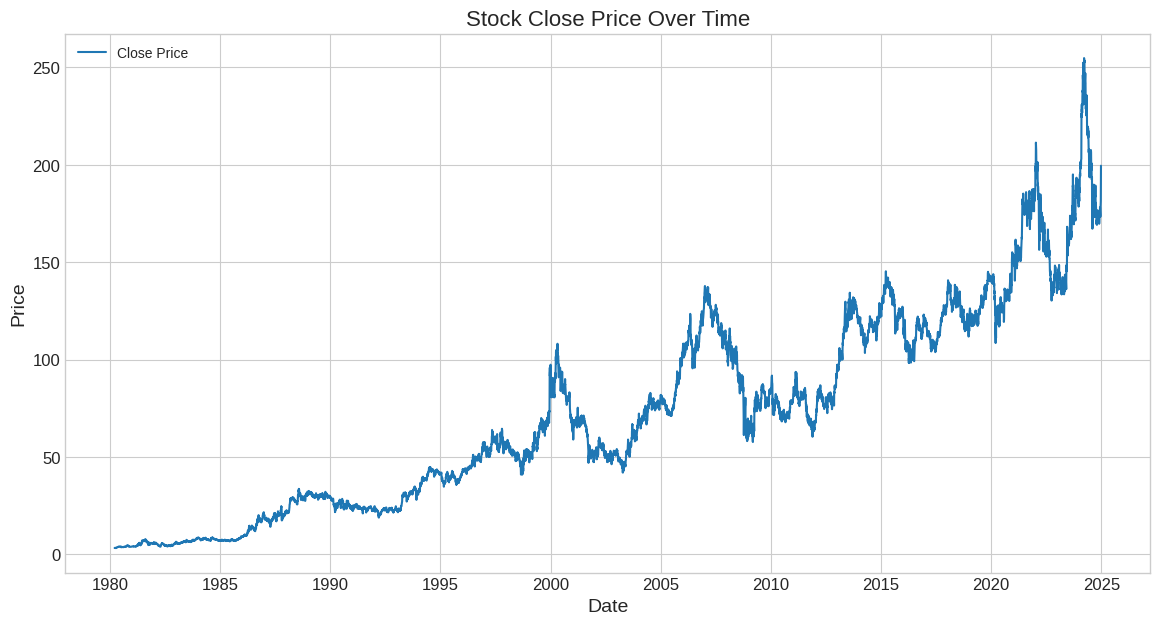


EDA Key Findings:
1. Average Daily Return: 0.0006
2. Volatility (Std of Daily Returns): 0.0186
3. Correlation between Close and Volume: 0.2973
4. Average Daily Price Gap: -26.3281%
5. Maximum Daily Return: 0.1935
6. Minimum Daily Return: -0.1652


In [ ]:
from ipywidgets import interact, IntSlider, Button, Layout
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Function to perform EDA with interactive navigation or matrix display
def perform_stock_eda(df, interactive=True):
    """
    Perform comprehensive EDA on stock price data.

    Parameters:
    df (pandas.DataFrame): DataFrame with stock price data.
    interactive (bool): If True, enables interactive navigation. If False, displays all graphs in a matrix.
    """
    # Ensure the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Drop rows with NaN in essential columns
    df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

    # Fill NaN values in calculated columns
    df['Daily_Return'] = df['Close'].pct_change()
    df['Daily_Return'].fillna(0, inplace=True)  # Replace NaN with 0

    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Gap_Percent'] = df['Gap'] / df['Close'].shift(1) * 100
    df['Gap_Percent'].fillna(0, inplace=True)  # Replace NaN with 0

    df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(20)
    df['Volatility'].fillna(0, inplace=True)  # Replace NaN with 0

    # 1. Basic statistics
    print("Basic Statistics:")
    print(df.describe())

    # Create a list of plots (functions that generate plots)
    def create_plots(df):
        plots = []

        # Plot 1: Close Price Over Time
        def plot_close_price():
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Close'], label='Close Price')
            plt.title('Stock Close Price Over Time')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.savefig('close_price_trend.png')
            plt.show()

        # Plot 2: Daily Returns
        def plot_daily_returns():
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Daily_Return'])
            plt.title('Daily Returns')
            plt.xlabel('Date')
            plt.ylabel('Return')
            plt.grid(True)
            plt.savefig('daily_returns.png')
            plt.show()

        # Plot 3: Distribution of Daily Returns
        def plot_returns_distribution():
            plt.figure(figsize=(14, 7))
            sns.histplot(df['Daily_Return'].dropna(), kde=True)
            plt.title('Distribution of Daily Returns')
            plt.xlabel('Daily Return')
            plt.savefig('returns_distribution.png')
            plt.show()

        # Plot 4: Trading Volume Analysis
        def plot_volume():
            plt.figure(figsize=(14, 7))
            plt.bar(df.index, df['Volume'])
            plt.title('Trading Volume Over Time')
            plt.xlabel('Date')
            plt.ylabel('Volume')
            plt.grid(True)
            plt.savefig('volume_trend.png')
            plt.show()

        # Plot 5: Correlation between Price and Volume
        def plot_volume_price_correlation():
            plt.figure(figsize=(10, 6))
            plt.scatter(df['Volume'], df['Close'])
            plt.title('Volume vs Close Price')
            plt.xlabel('Volume')
            plt.ylabel('Close Price')
            plt.grid(True)
            plt.savefig('volume_price_correlation.png')
            plt.show()

        # Plot 6: Correlation Matrix
        def plot_correlation_matrix():
            correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
            plt.title('Correlation Matrix')
            plt.savefig('correlation_matrix.png')
            plt.show()

        # Plot 7: Moving Averages
        def plot_moving_averages():
            df['MA5'] = df['Close'].rolling(window=5).mean()
            df['MA20'] = df['Close'].rolling(window=20).mean()
            df['MA50'] = df['Close'].rolling(window=50).mean()
            df['MA200'] = df['Close'].rolling(window=200).mean()
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Close'], label='Close')
            plt.plot(df.index, df['MA5'], label='MA5')
            plt.plot(df.index, df['MA20'], label='MA20')
            plt.plot(df.index, df['MA50'], label='MA50')
            plt.plot(df.index, df['MA200'], label='MA200')
            plt.title('Stock Price with Moving Averages')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.savefig('moving_averages.png')
            plt.show()

        # Plot 8: Volatility Analysis
        def plot_volatility():
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Volatility'])
            plt.title('20-Day Rolling Volatility')
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.grid(True)
            plt.savefig('volatility.png')
            plt.show()

        # Plot 9: Seasonal Decomposition
        def plot_seasonal_decomposition():
            if len(df) >= 252 * 2:  # 252 trading days in a year * 2 years
                from statsmodels.tsa.seasonal import seasonal_decompose
                decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
                decomposition.observed.plot(ax=ax1)
                ax1.set_title('Observed')
                decomposition.trend.plot(ax=ax2)
                ax2.set_title('Trend')
                decomposition.seasonal.plot(ax=ax3)
                ax3.set_title('Seasonality')
                decomposition.resid.plot(ax=ax4)
                ax4.set_title('Residuals')
                plt.tight_layout()
                plt.savefig('seasonal_decomposition.png')
                plt.show()
            else:
                print("Not enough data for seasonal decomposition. Ideally need > 2 years of data.")

        # Plot 10: OHLC Candlestick Chart
        def plot_candlestick():
            recent_df = df.tail(90).copy()
            fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                                vertical_spacing=0.03, subplot_titles=('Stock Price', 'Volume'),
                                row_width=[0.2, 0.7])
            fig.add_trace(go.Candlestick(
                x=recent_df.index,
                open=recent_df['Open'],
                high=recent_df['High'],
                low=recent_df['Low'],
                close=recent_df['Close'],
                name='OHLC'
            ), row=1, col=1)
            fig.add_trace(go.Bar(
                x=recent_df.index,
                y=recent_df['Volume'],
                name='Volume',
                marker_color='rgba(0, 0, 255, 0.5)'
            ), row=2, col=1)
            fig.update_layout(
                height=800,
                width=1200,
                title_text='Stock Price Analysis',
                xaxis_rangeslider_visible=False
            )
            fig.write_image('candlestick_chart.png')
            fig.show()

        # Plot 11: Price Gaps Analysis
        def plot_price_gaps():
            plt.figure(figsize=(14, 7))
            plt.bar(df.index, df['Gap_Percent'])
            plt.axhline(y=0, color='r', linestyle='-')
            plt.title('Daily Price Gaps (in %)')
            plt.xlabel('Date')
            plt.ylabel('Gap Percentage')
            plt.grid(True)
            plt.savefig('price_gaps.png')
            plt.show()

        # Add all plots to the list
        plots.append(plot_close_price)
        plots.append(plot_daily_returns)
        plots.append(plot_returns_distribution)
        plots.append(plot_volume)
        plots.append(plot_volume_price_correlation)
        plots.append(plot_correlation_matrix)
        plots.append(plot_moving_averages)
        plots.append(plot_volatility)
        plots.append(plot_seasonal_decomposition)
        plots.append(plot_candlestick)
        plots.append(plot_price_gaps)

        return plots

    # Create the list of plots
    plots = create_plots(df)

    # Interactive Navigation
    if interactive:
        class PlotNavigator:
            def __init__(self, plots):
                self.plots = plots
                self.index = 0
                self.max_index = len(plots) - 1

                # Create buttons
                self.next_button = Button(description='Next →', layout=Layout(width='100px'))
                self.prev_button = Button(description='← Previous', layout=Layout(width='100px'))

                # Attach button click handlers
                self.next_button.on_click(self.next_plot)
                self.prev_button.on_click(self.prev_plot)

                # Display the first plot
                self.show_plot()

            def show_plot(self):
                # Clear the current output and display the new plot
                clear_output(wait=True)
                display(widgets.HBox([self.prev_button, self.next_button]))
                self.plots[self.index]()

            def next_plot(self, b):
                if self.index < self.max_index:
                    self.index += 1
                    self.show_plot()

            def prev_plot(self, b):
                if self.index > 0:
                    self.index -= 1
                    self.show_plot()

        # Initialize and display the navigator
        navigator = PlotNavigator(plots)
    else:
        # Display all plots in a matrix format
        fig, axes = plt.subplots(4, 3, figsize=(20, 20))
        axes = axes.ravel()

        for i, plot in enumerate(plots):
            plot()
            plt.close()  # Close individual plots to avoid displaying them twice

    # Print summary of findings
    print("\nEDA Key Findings:")
    print(f"1. Average Daily Return: {df['Daily_Return'].mean():.4f}")
    print(f"2. Volatility (Std of Daily Returns): {df['Daily_Return'].std():.4f}")
    print(f"3. Correlation between Close and Volume: {df['Close'].corr(df['Volume']):.4f}")
    print(f"4. Average Daily Price Gap: {df['Gap_Percent'].mean():.4f}%")
    print(f"5. Maximum Daily Return: {df['Daily_Return'].max():.4f}")
    print(f"6. Minimum Daily Return: {df['Daily_Return'].min():.4f}")

    return df  # Return the dataframe with added indicators

# Call the EDA function
df = perform_stock_eda(df, interactive=True)  # Set interactive=False for matrix display

In [ ]:
df.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Gap,Gap_Percent,Volatility
Date,,,,,,,,,,
1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0,0.000000,NaN,0.0,0.0
1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0,0.004065,-3.291227,-100.0,0.0
1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0,0.000000,0.000000,0.0,0.0
1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0,0.000000,-3.304606,-100.0,0.0
1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0,0.024292,-3.304606,-100.0,0.0


# **Generating Report of EDA**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 84.9 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)


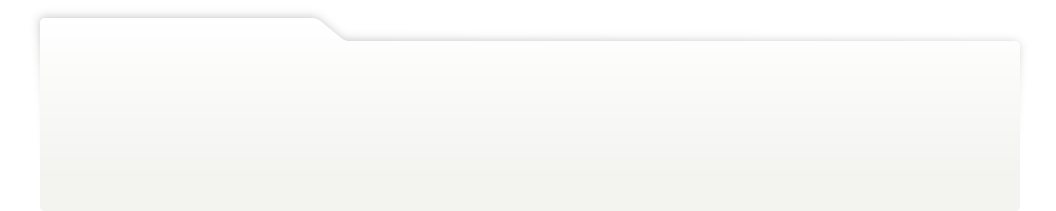
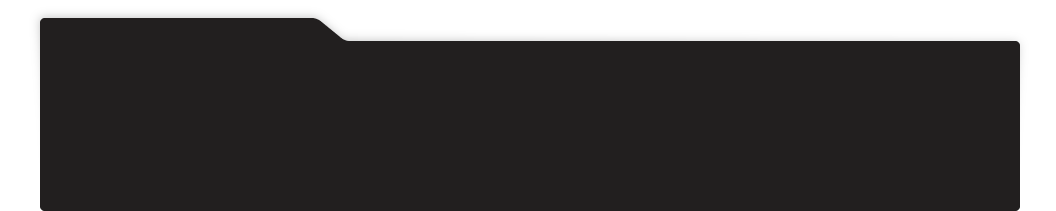
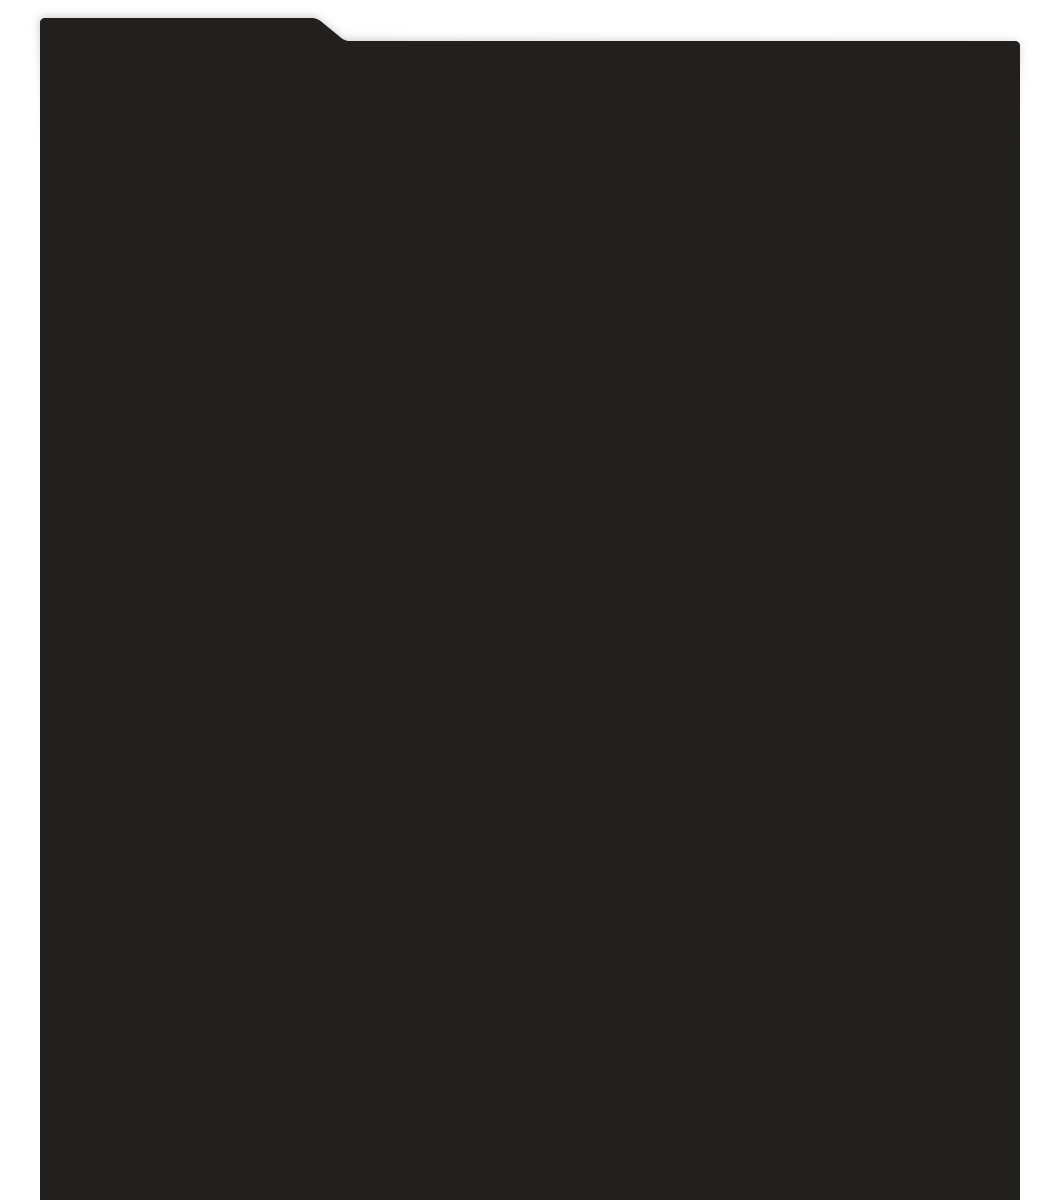
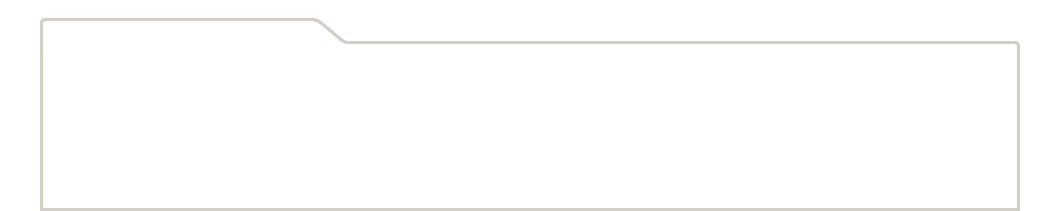
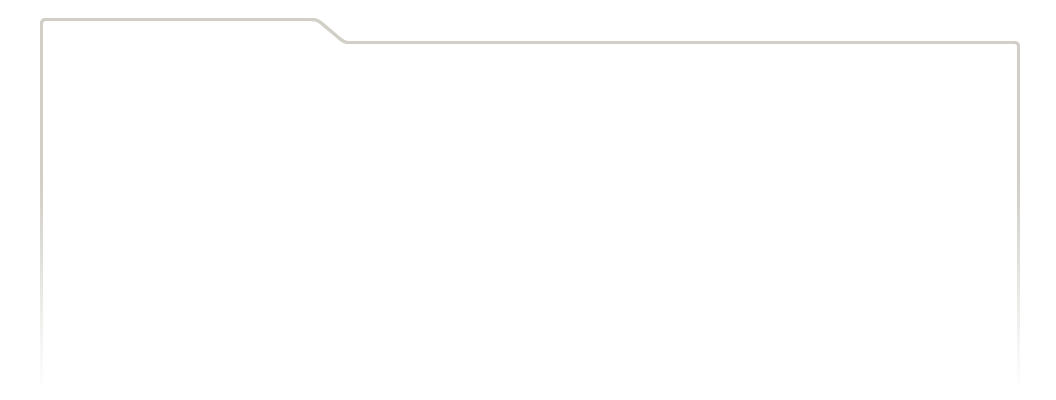
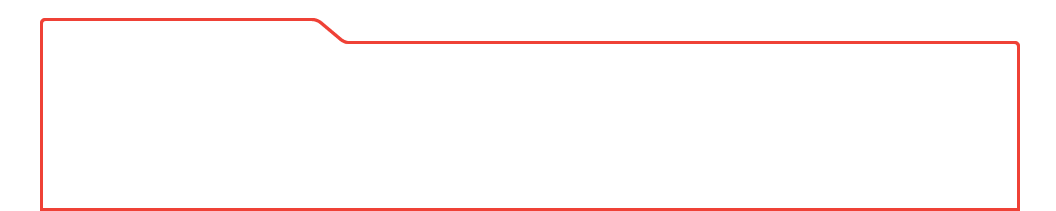
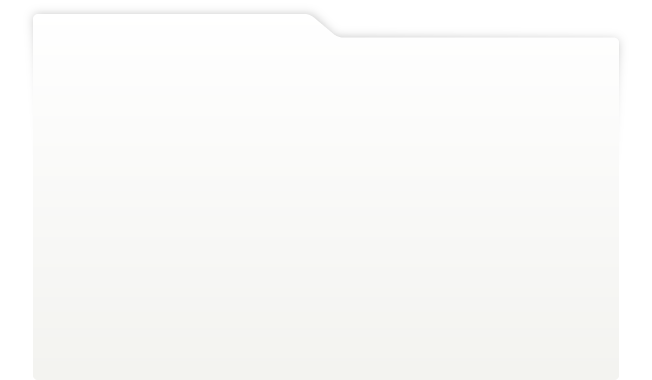
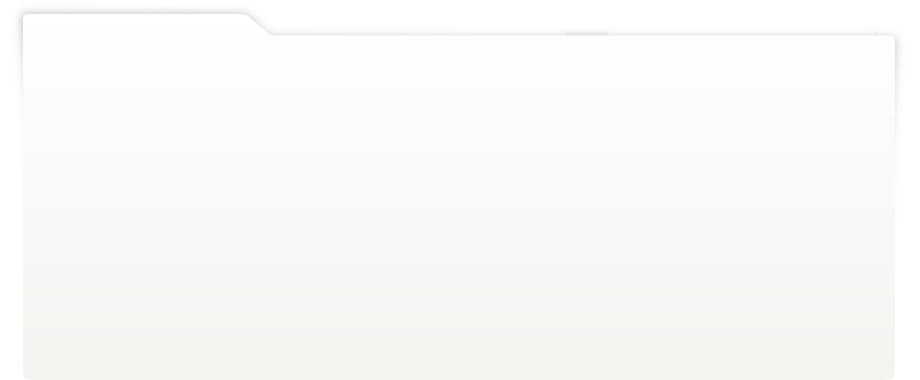
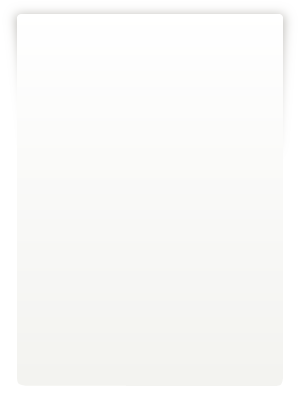
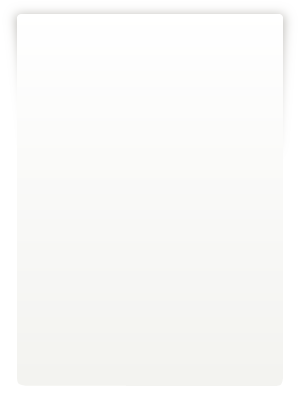
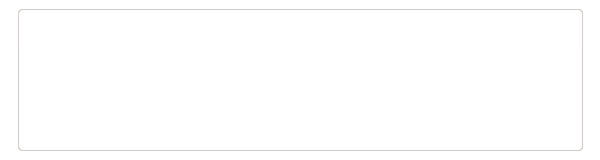
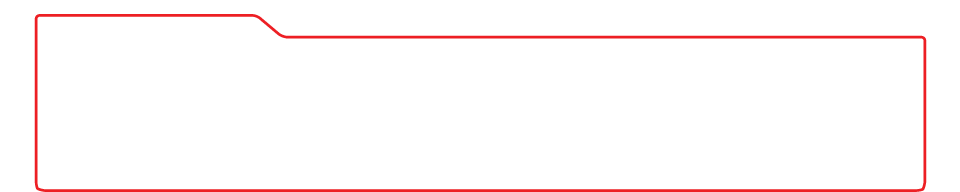
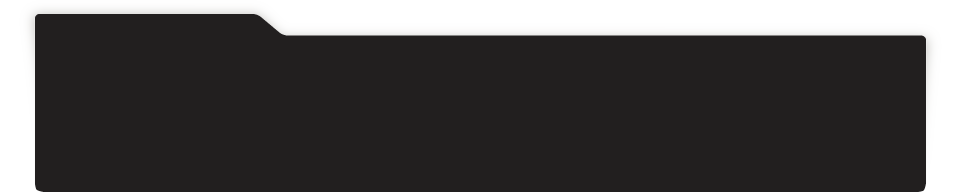
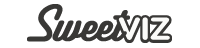
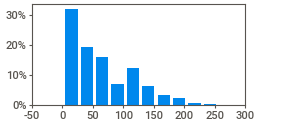
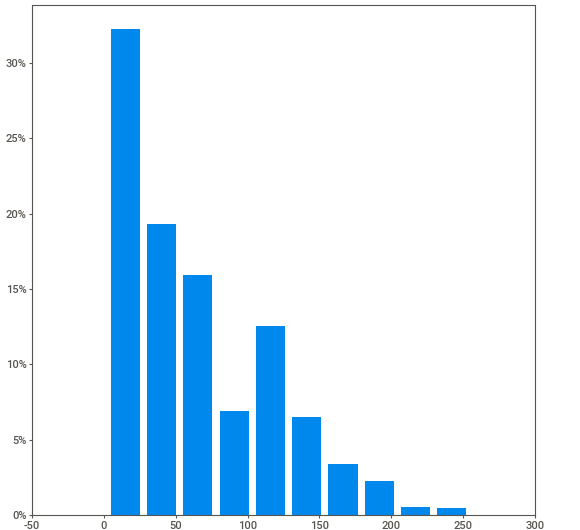
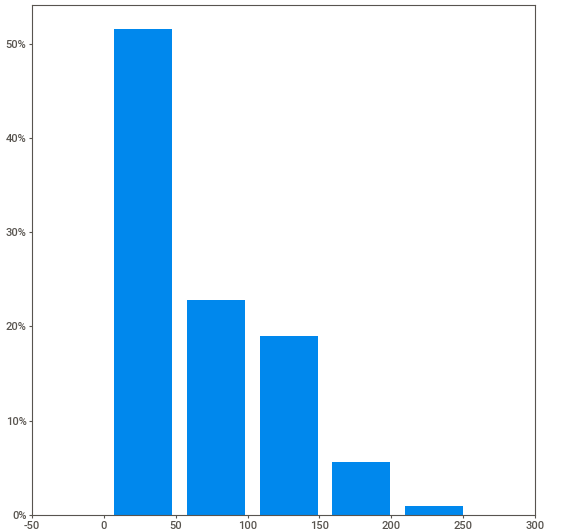
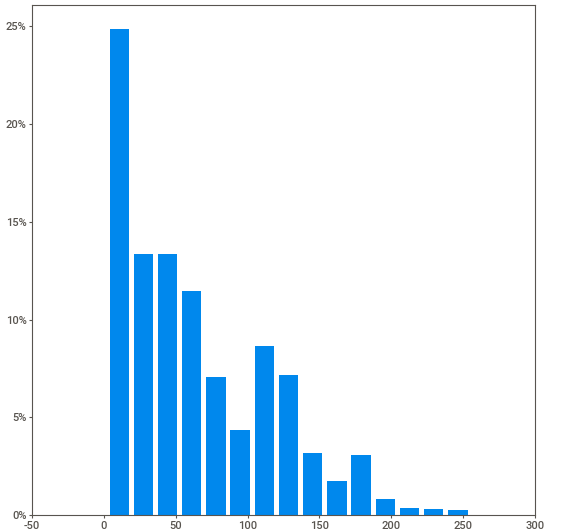
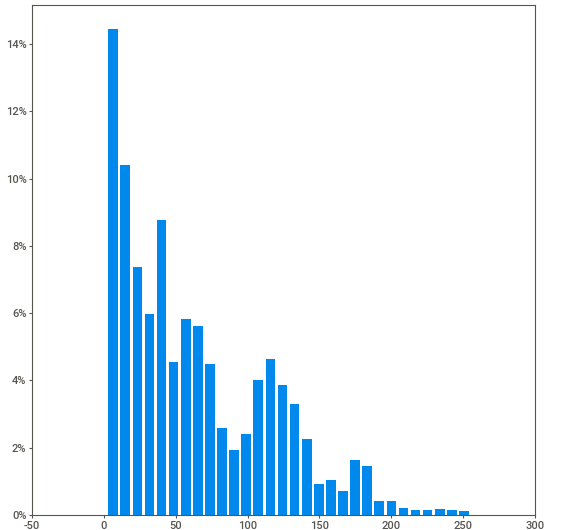
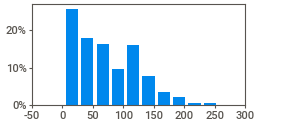
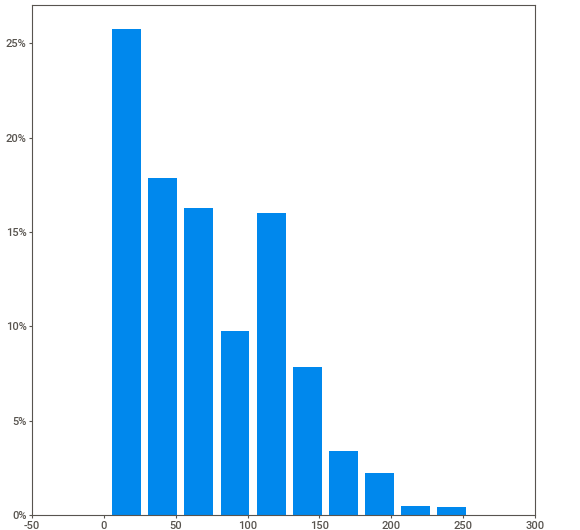
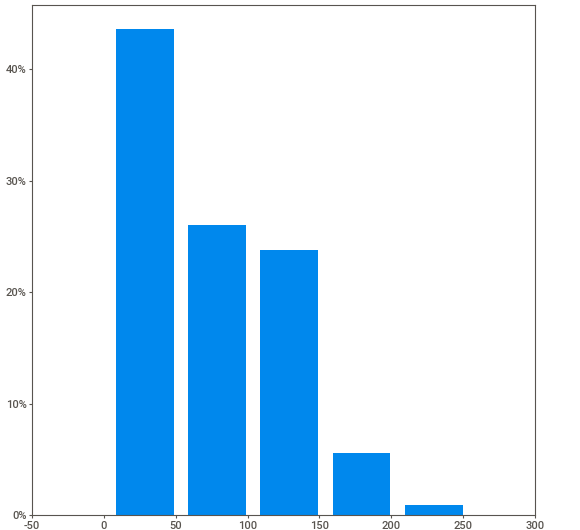
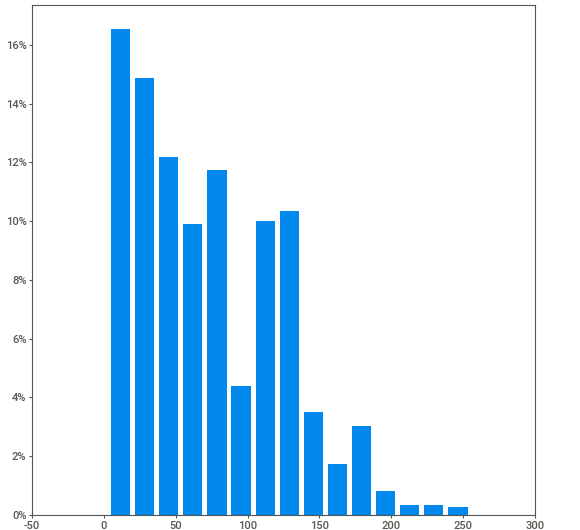
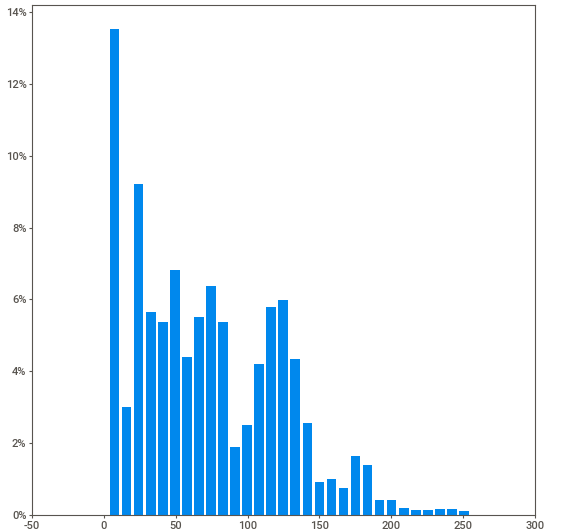
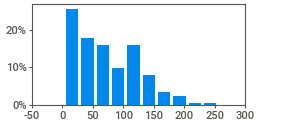
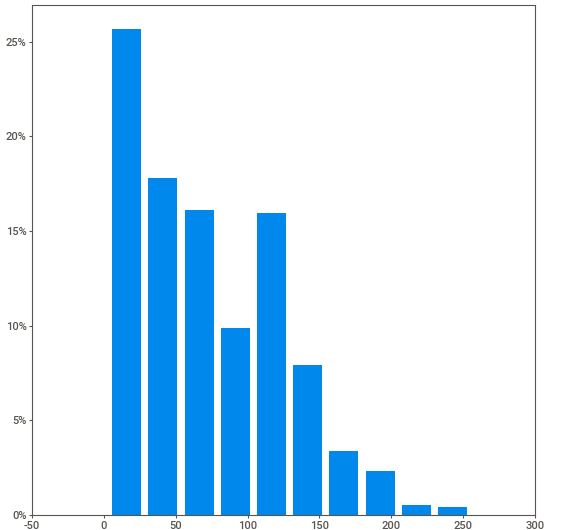
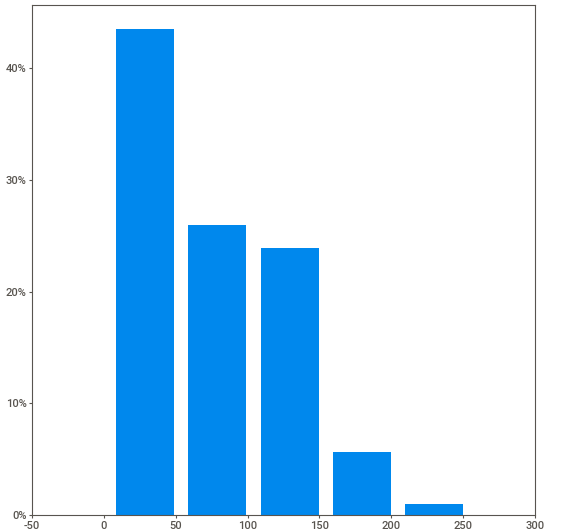
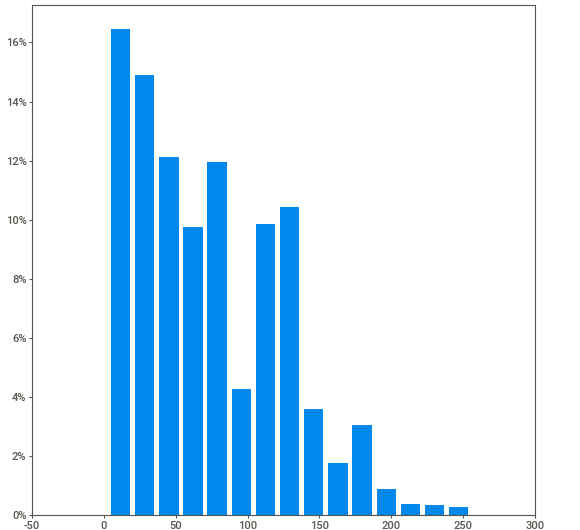
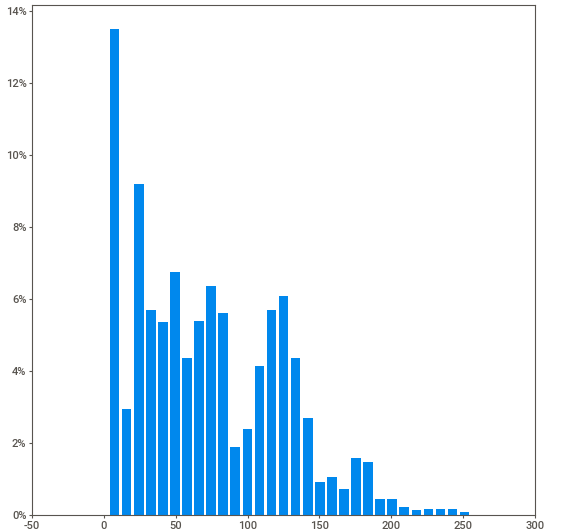
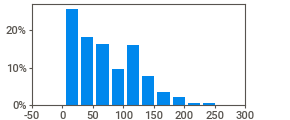
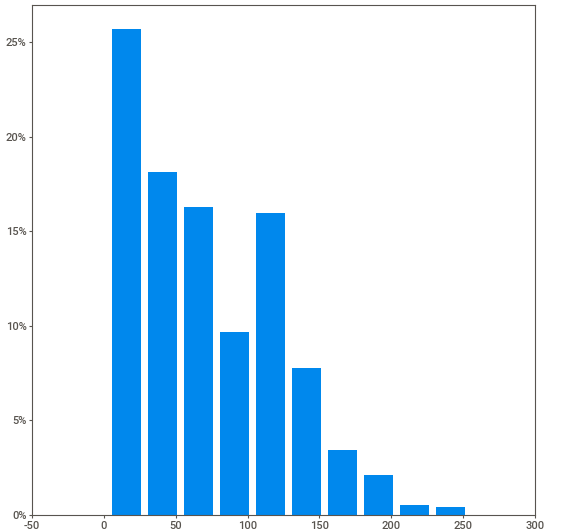
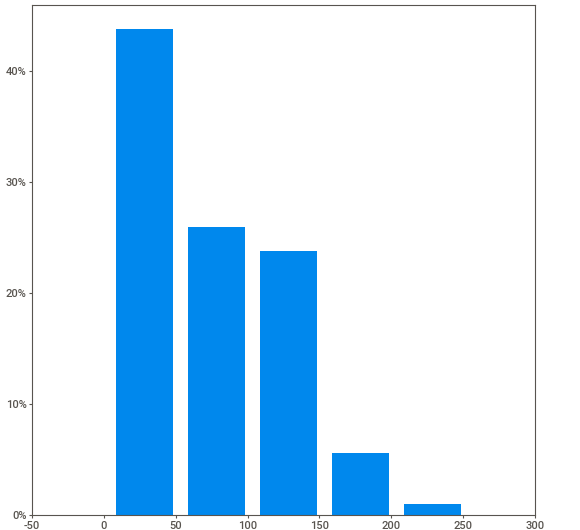
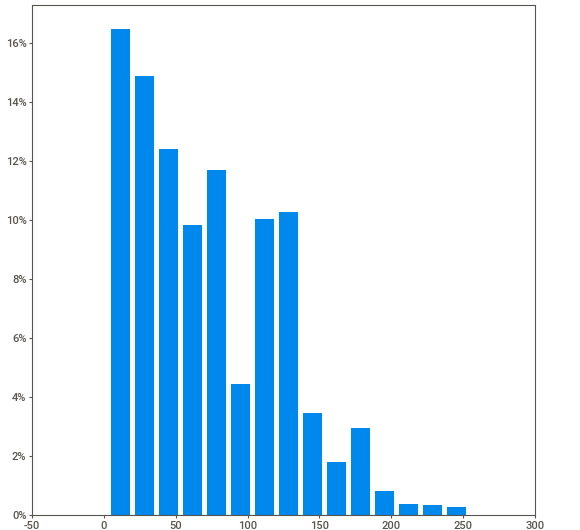
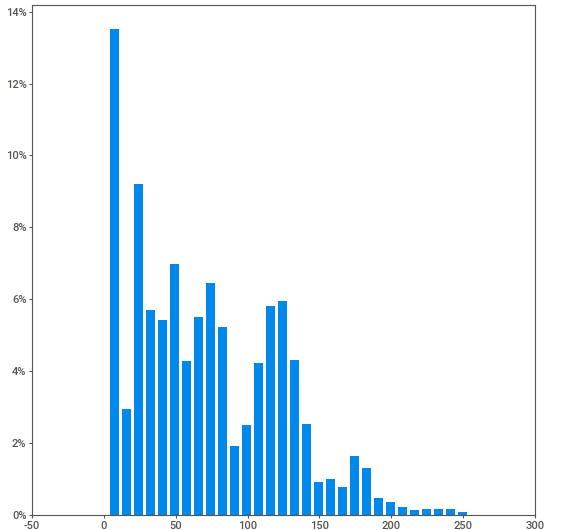
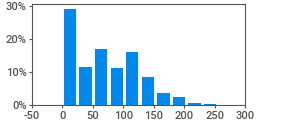
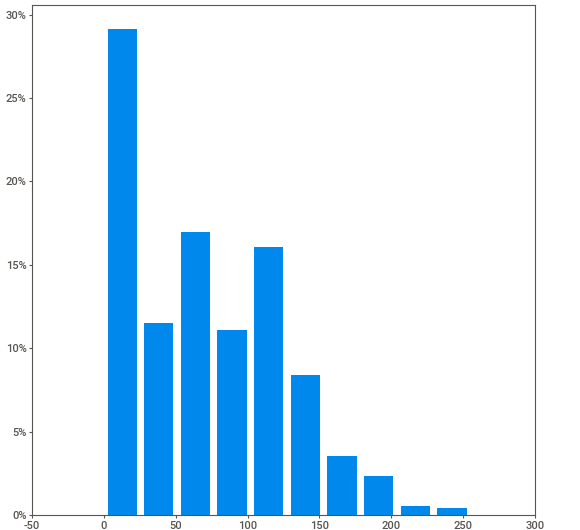
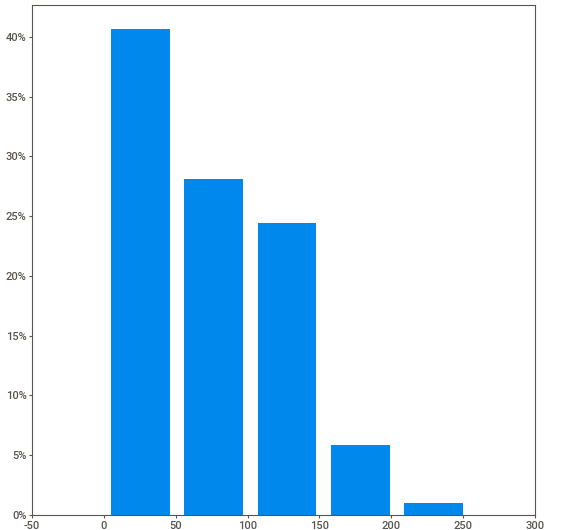
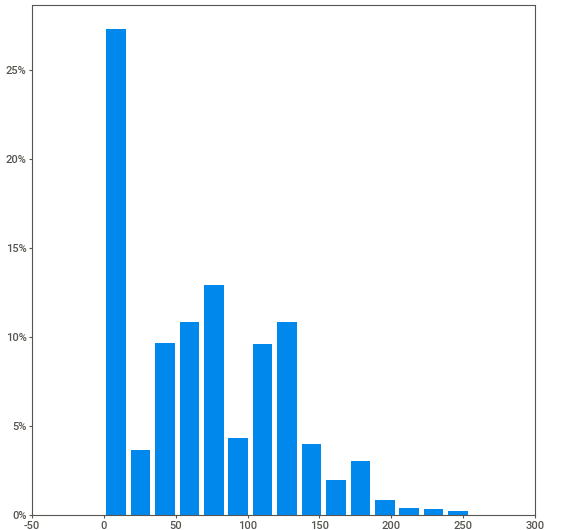
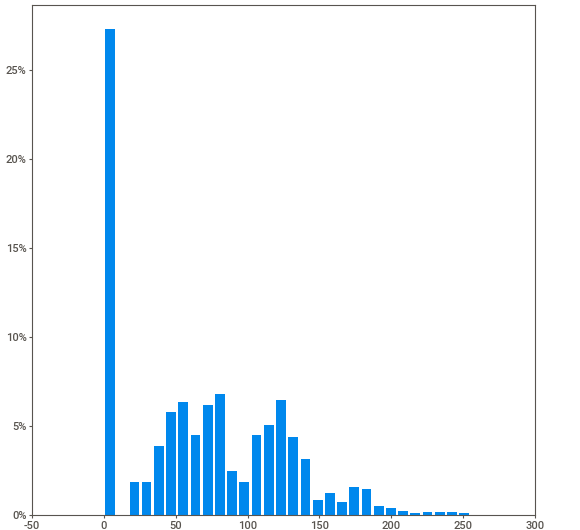
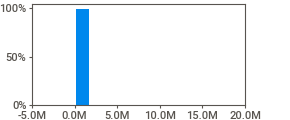
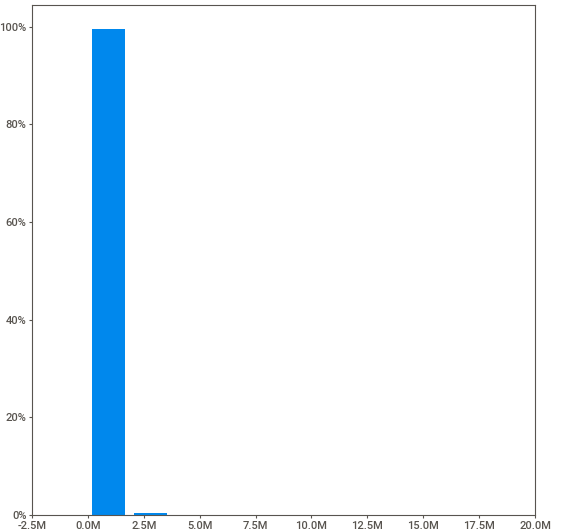
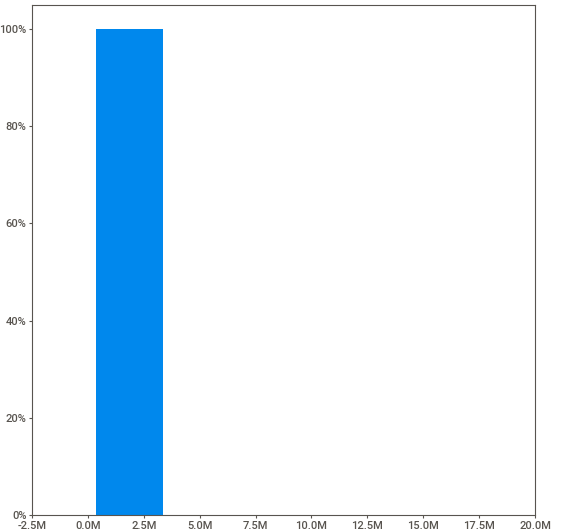
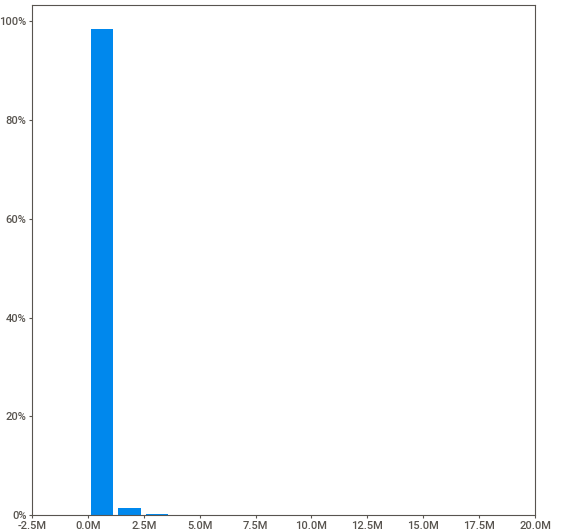
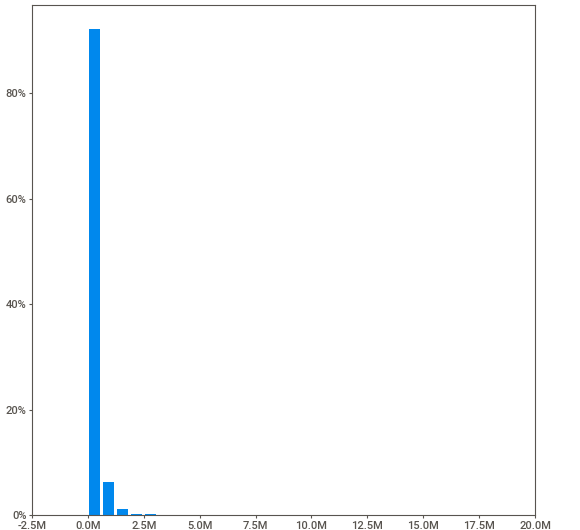
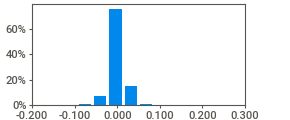
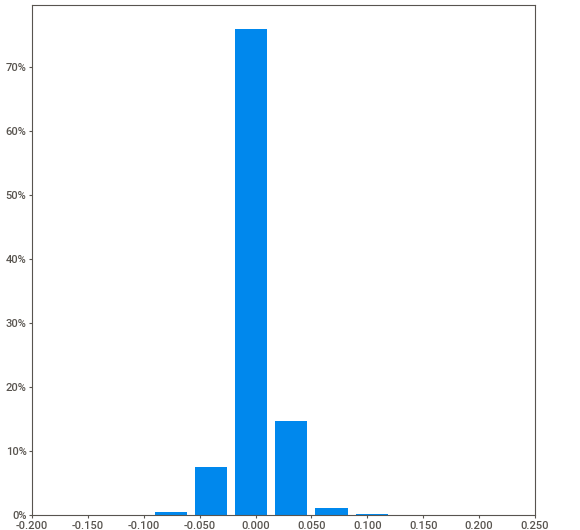
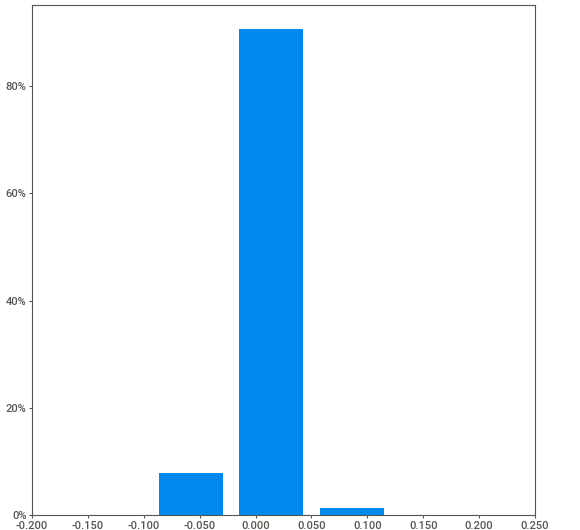
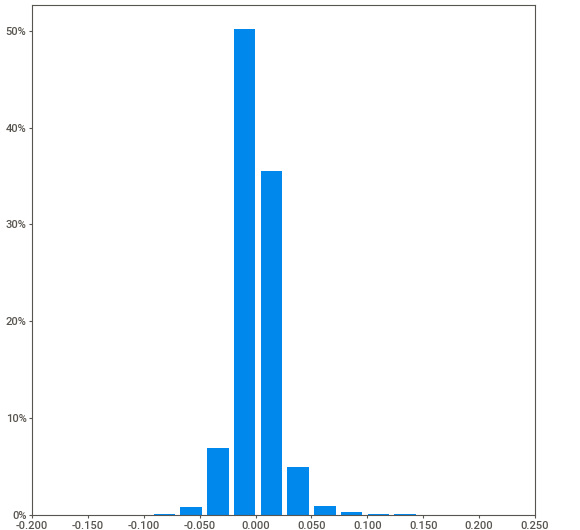
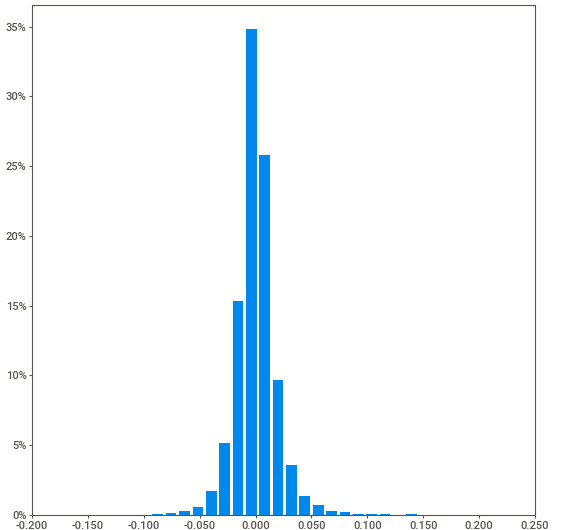
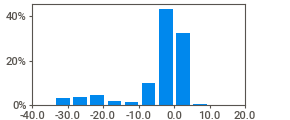
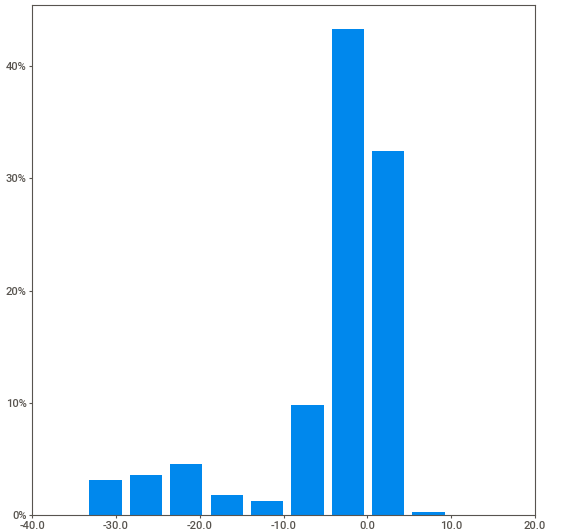
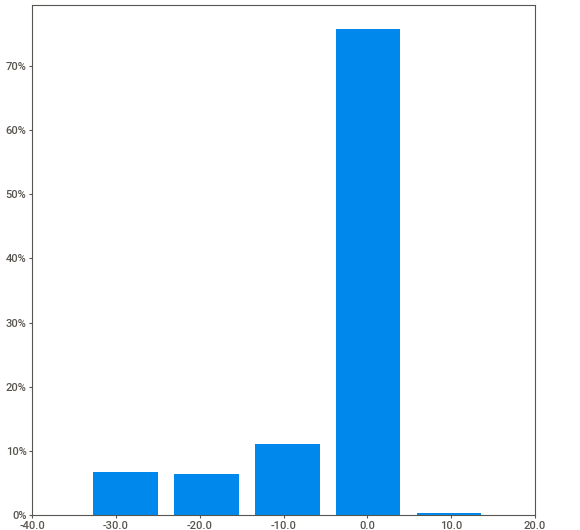
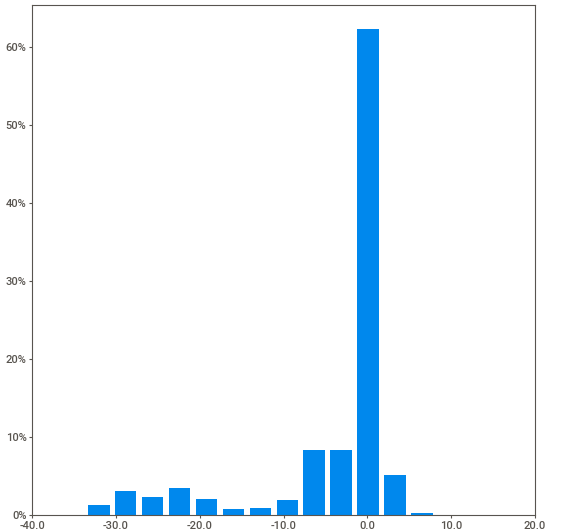
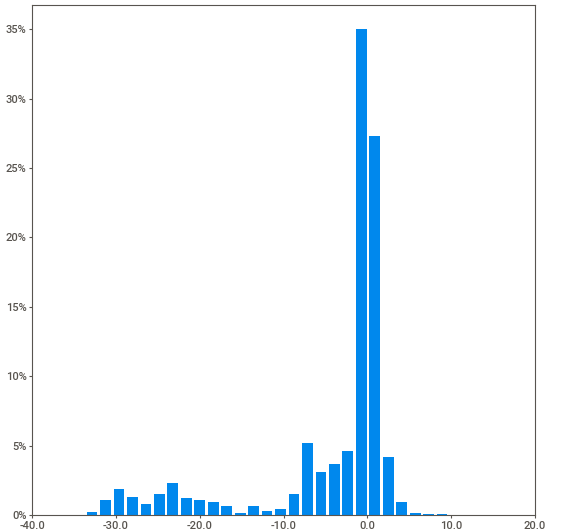
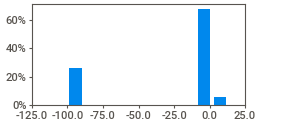
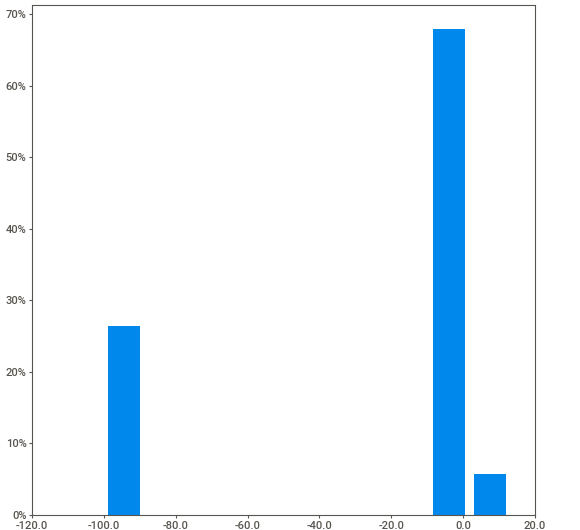
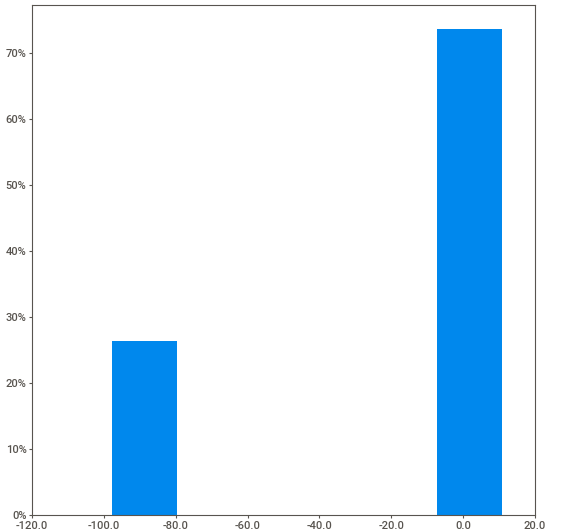
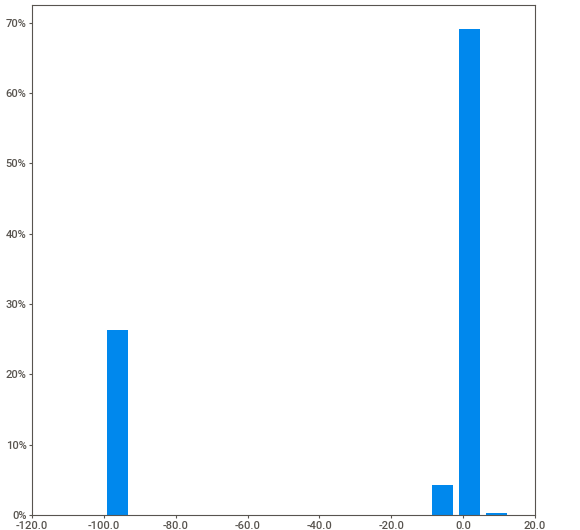
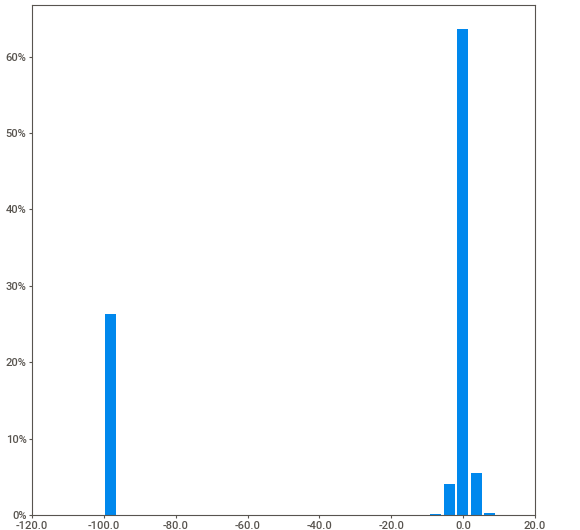
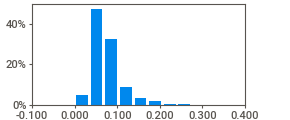
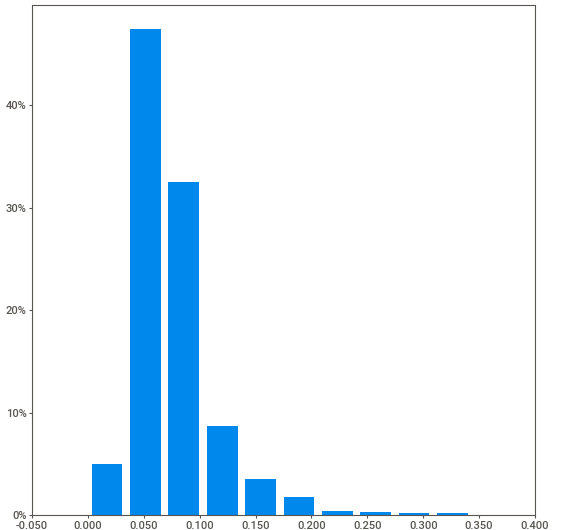
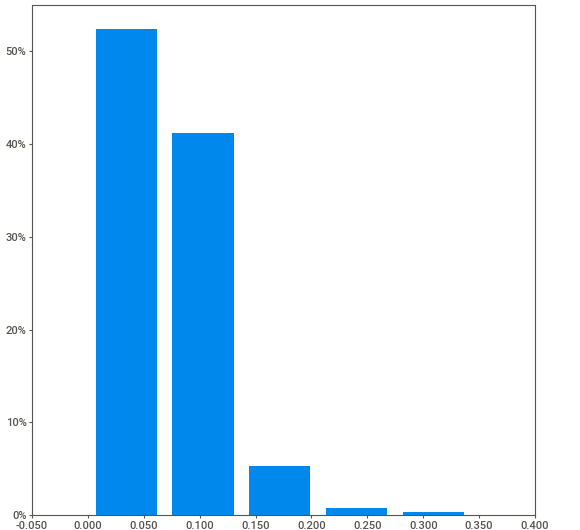
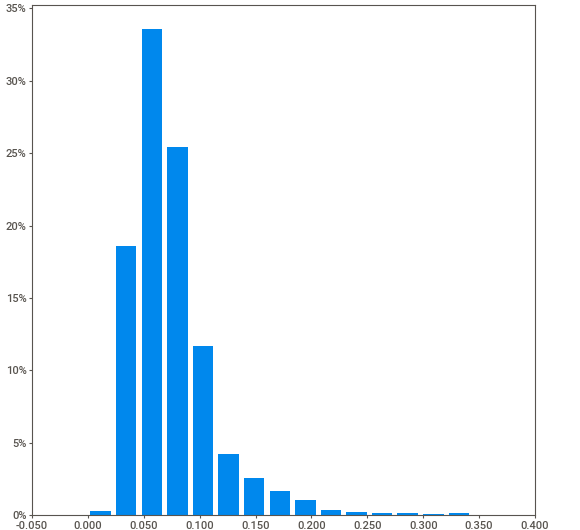
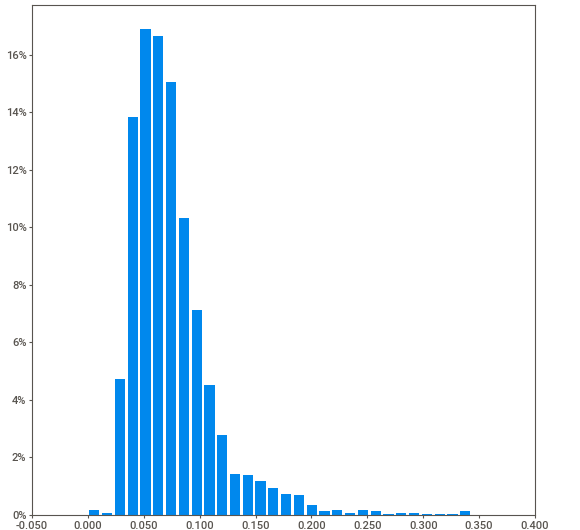
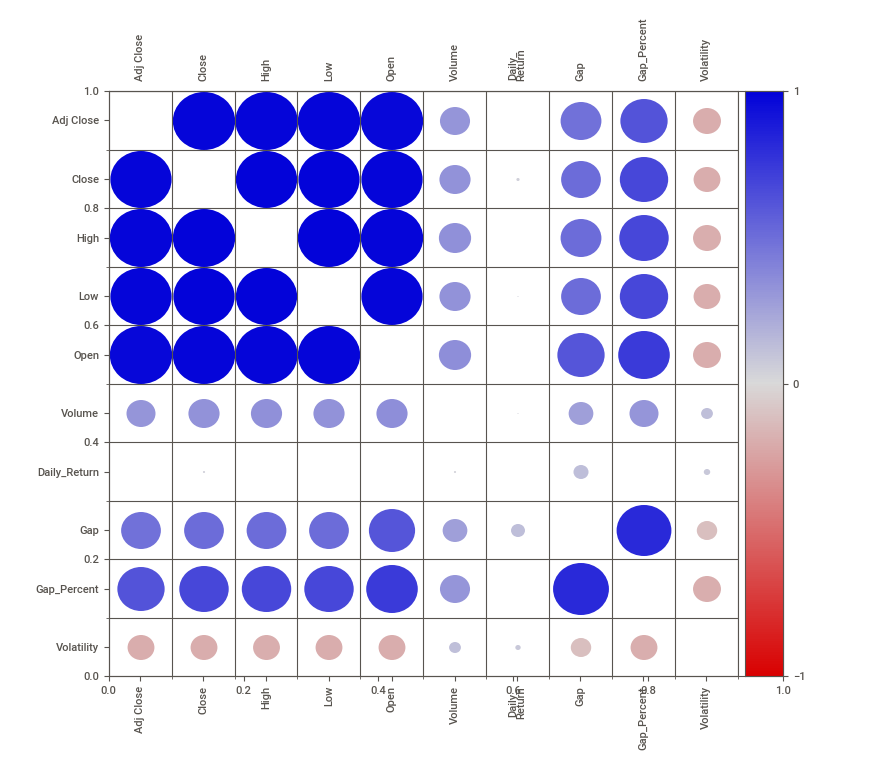
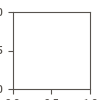

Report stock_price_eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install sweetviz
!pip install sweetviz

# Import and generate the report
import sweetviz as sv

report = sv.analyze(df)

# Display the report in Colab
report.show_notebook()

# Save the report as an HTML file
report.show_html("stock_price_eda_report.html")

# Download the report
from google.colab import files
files.download("stock_price_eda_report.html")

# **Time Series Analysis**


1. Visualizing the Close price time series...


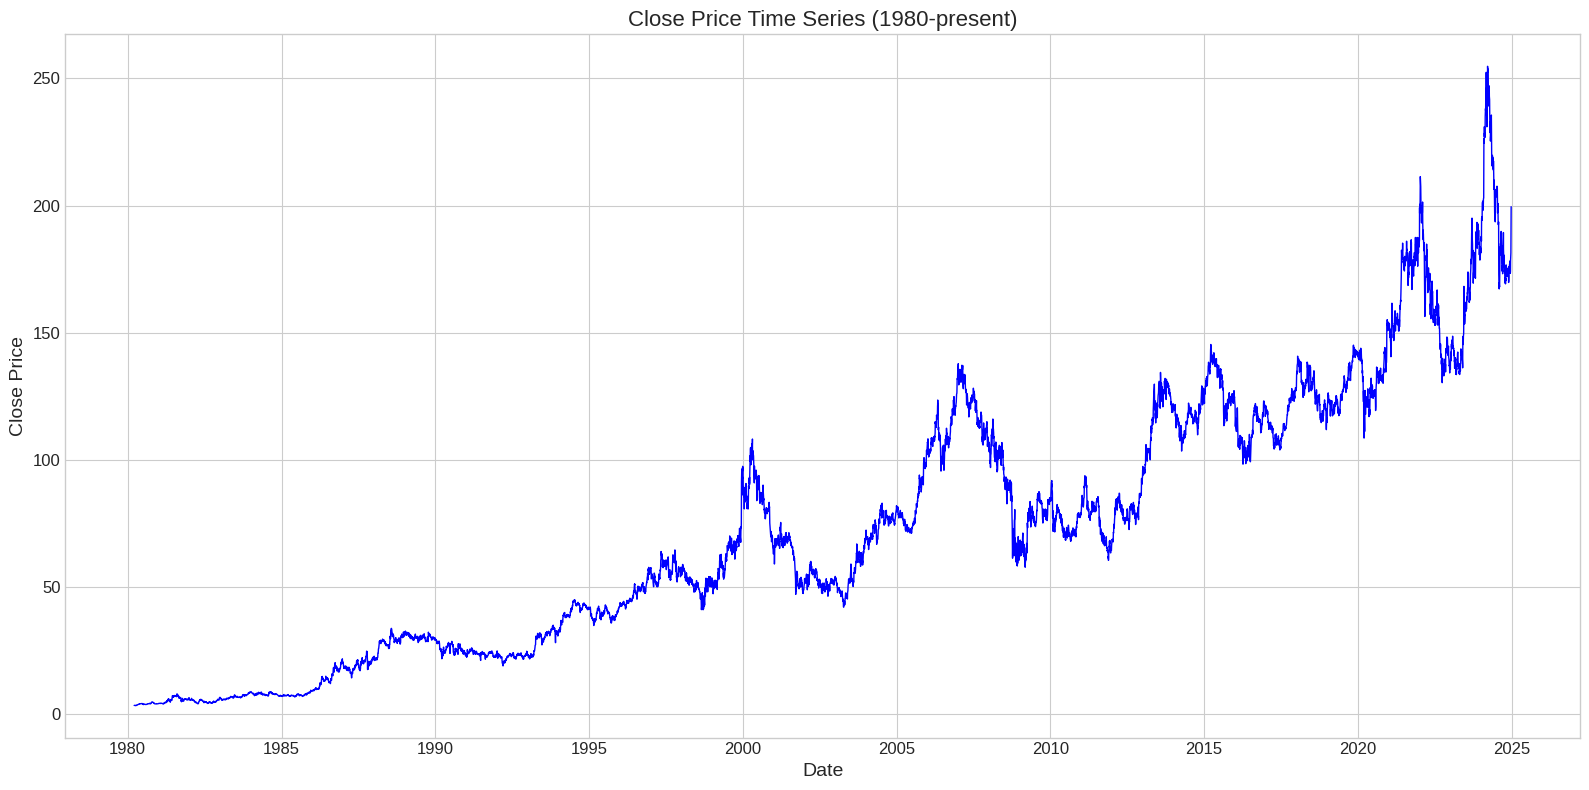


2. Checking for stationarity...


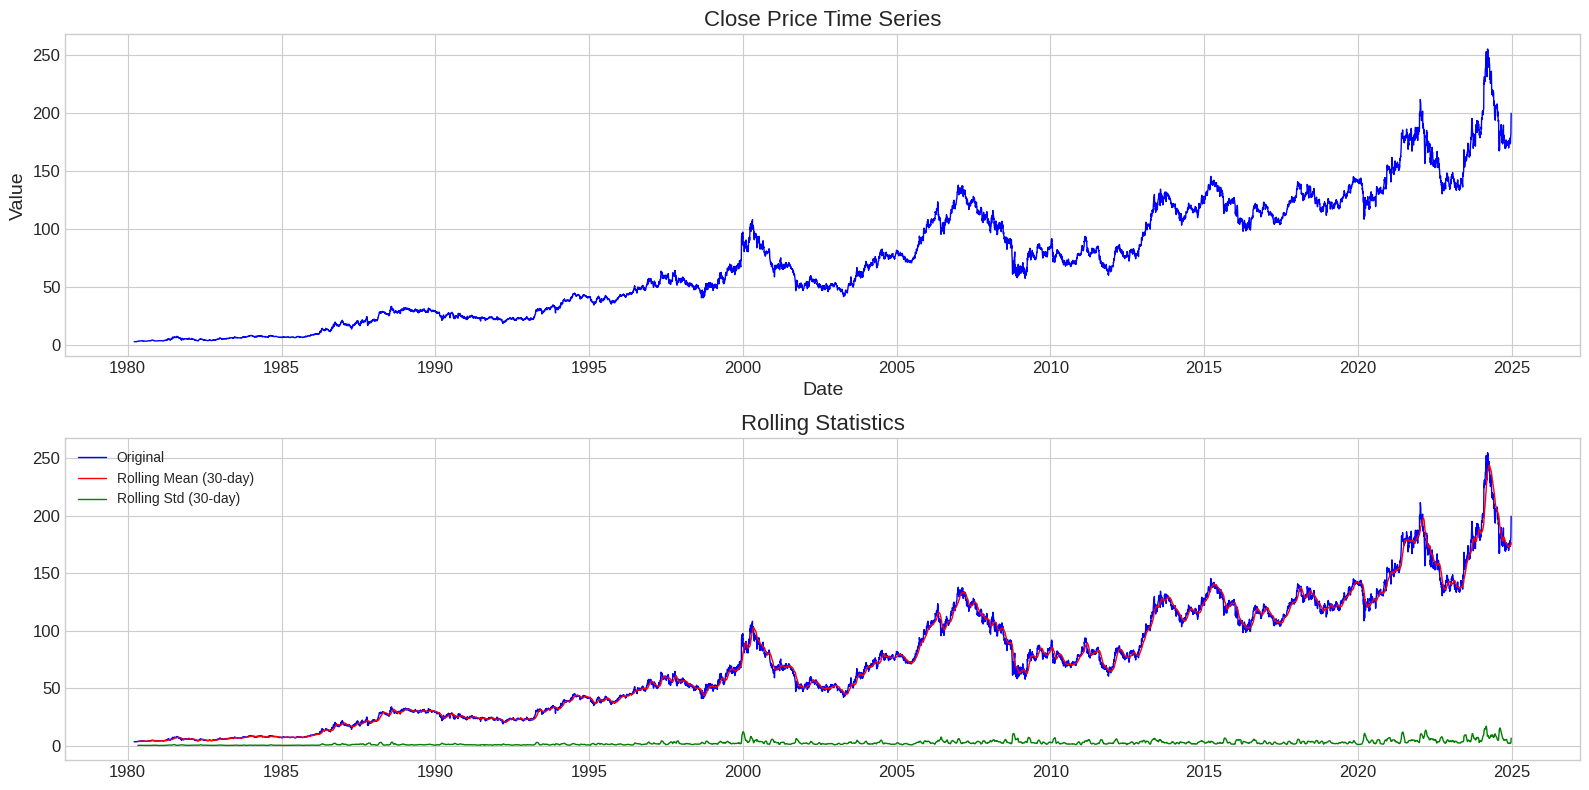

ADF Statistic: -0.487906839546852
p-value: 0.8943548694699559
Critical Values:
   1%: -3.4309684651937102
   5%: -2.861813326465428
   10%: -2.566915486535681
The series is non-stationary.

3. Applying differencing...

After differencing:


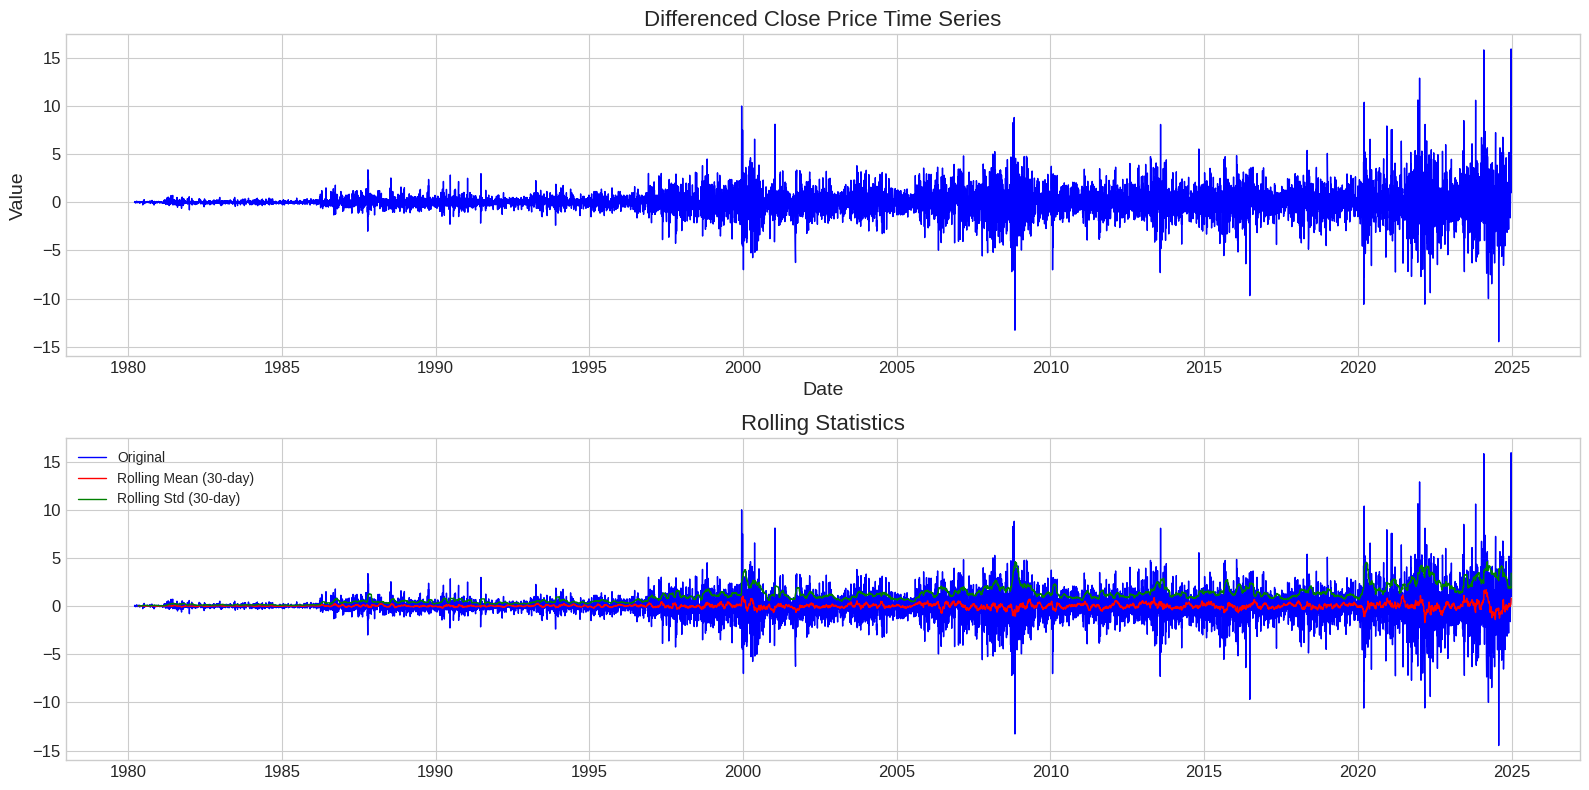

ADF Statistic: -18.252383304103905
p-value: 2.3412713892646427e-30
Critical Values:
   1%: -3.430973299056796
   5%: -2.861815462534042
   10%: -2.566916623563633
The series is stationary.

4. Performing seasonal decomposition...


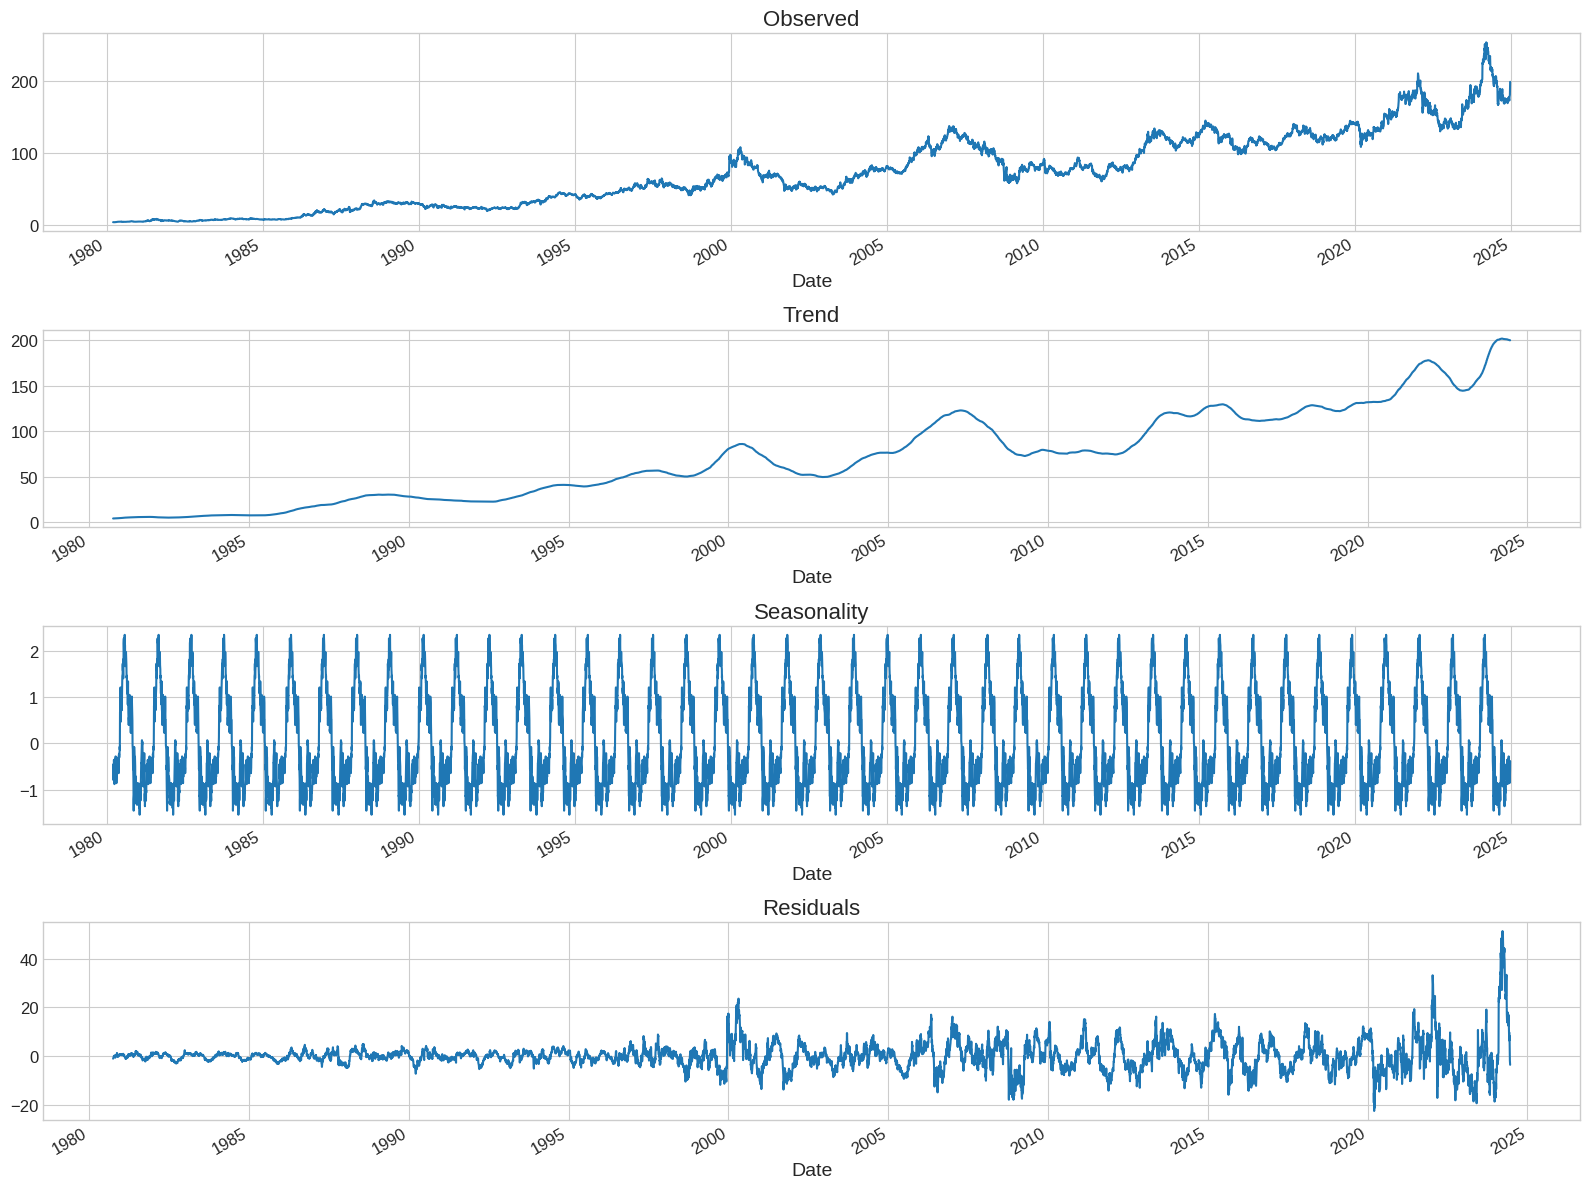


5. Plotting ACF and PACF...


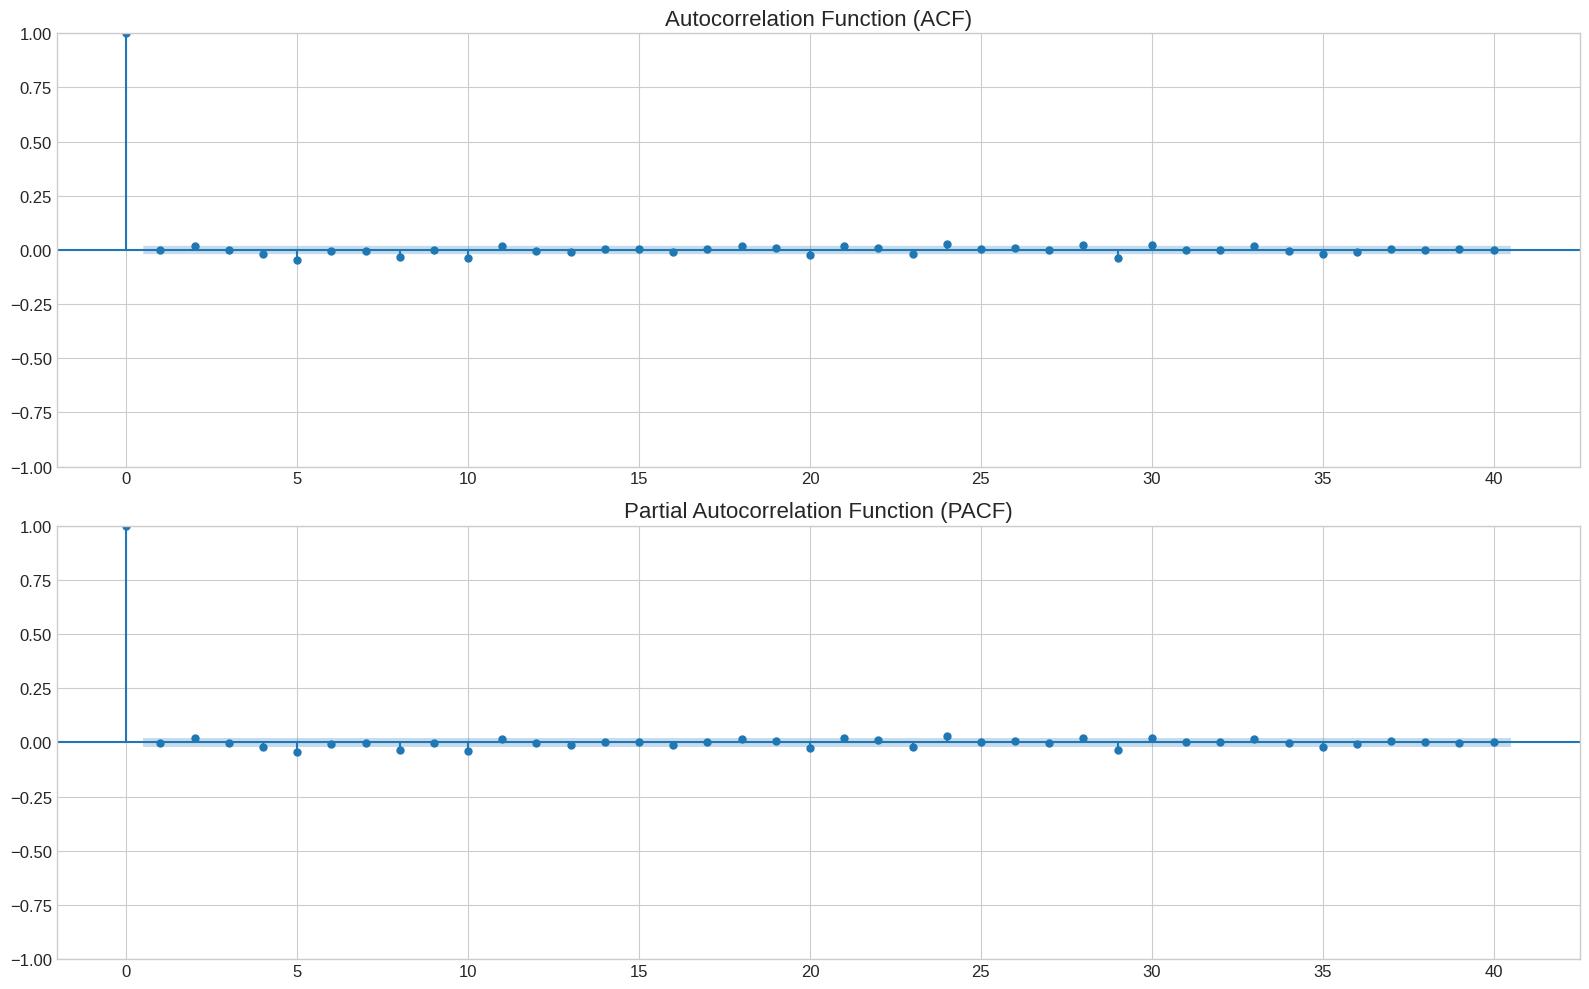


6. Fitting ARIMA model...
Training data: 8492 observations
Testing data: 2124 observations

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8492
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12804.144
Date:                Sun, 09 Mar 2025   AIC                          25614.289
Time:                        18:11:31   BIC                          25635.429
Sample:                             0   HQIC                         25621.503
                               - 8492                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8450      0.034     25.195      0.000       0.779       0.911
ma.L1         -0.

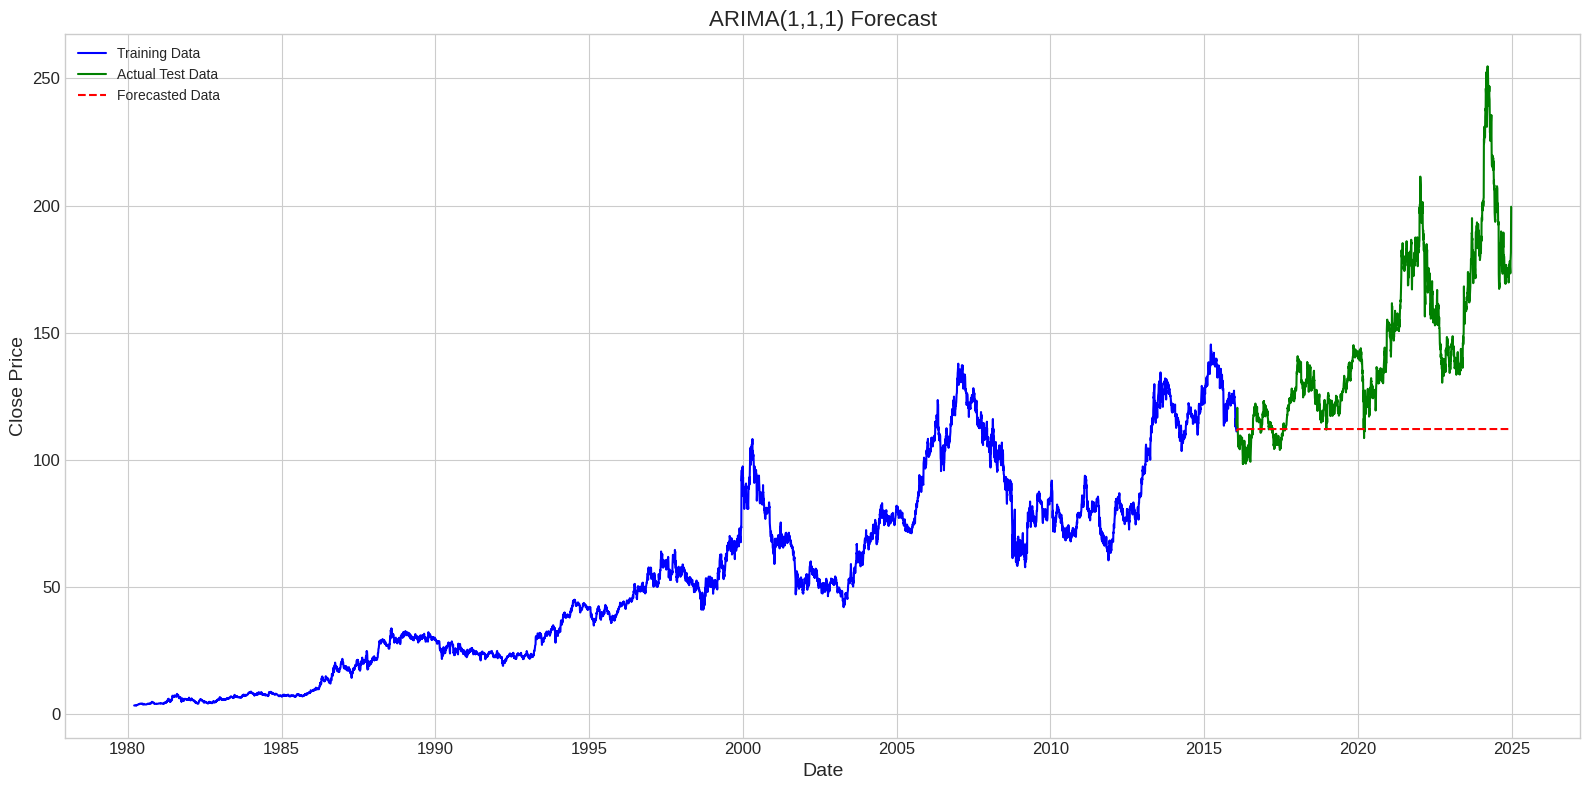


7. Forecast Evaluation:
Mean Squared Error (MSE): 2078.9006
Root Mean Squared Error (RMSE): 45.5950
Mean Absolute Error (MAE): 34.1870
Mean Absolute Percentage Error (MAPE): nan%


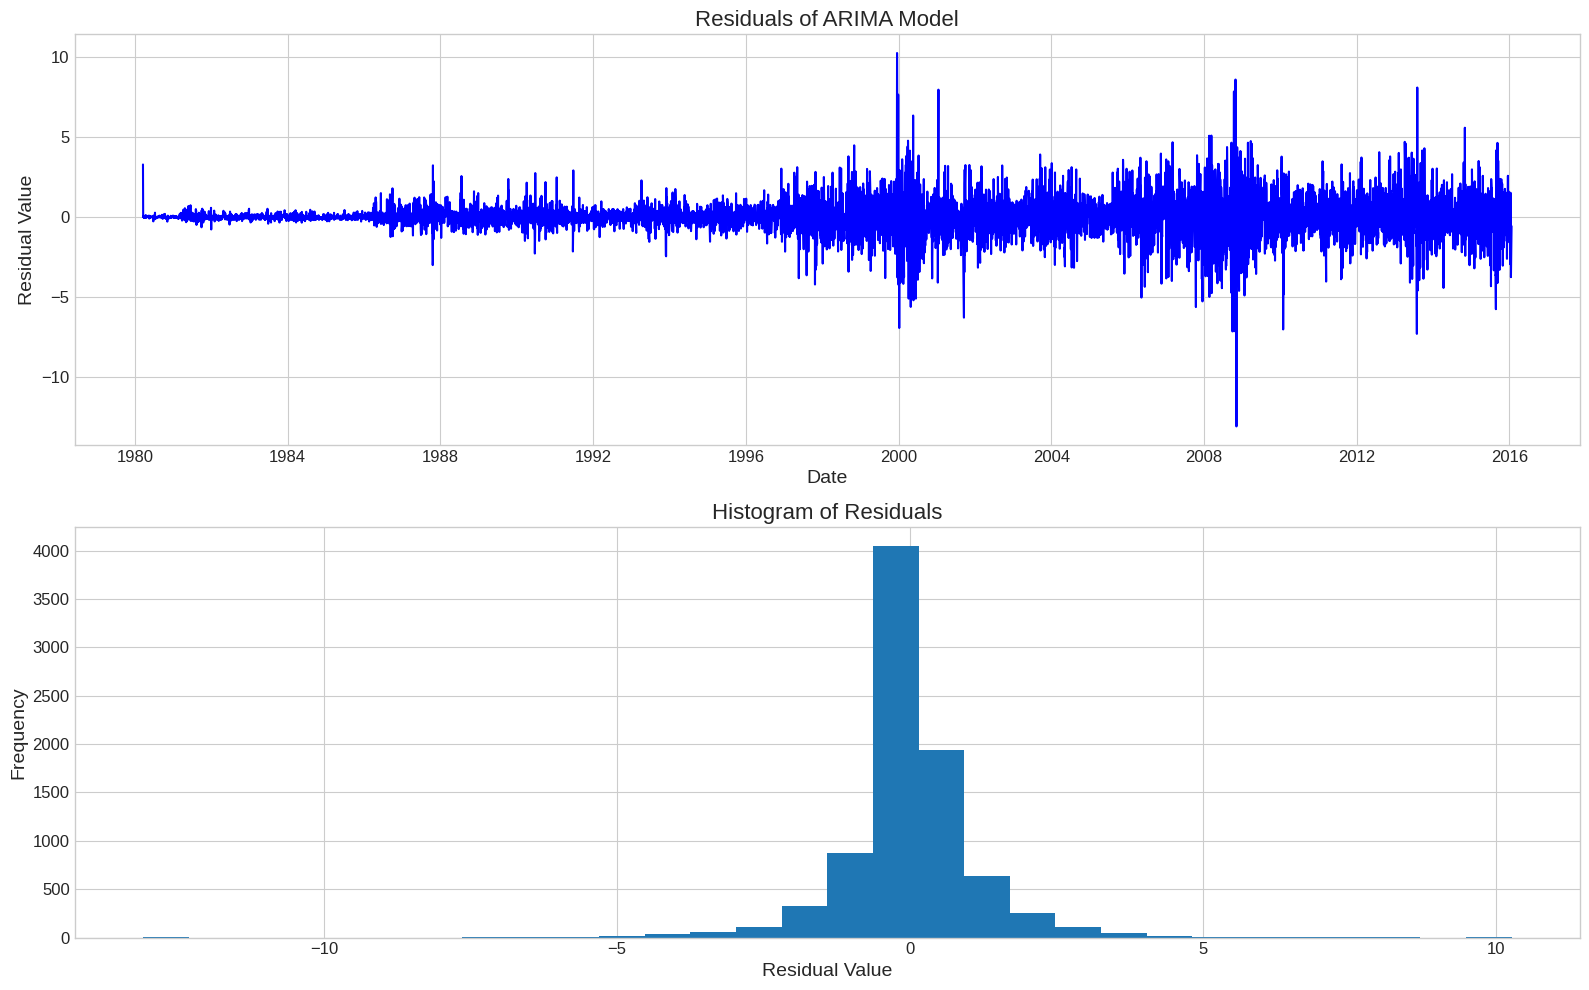

<Figure size 1600x800 with 0 Axes>

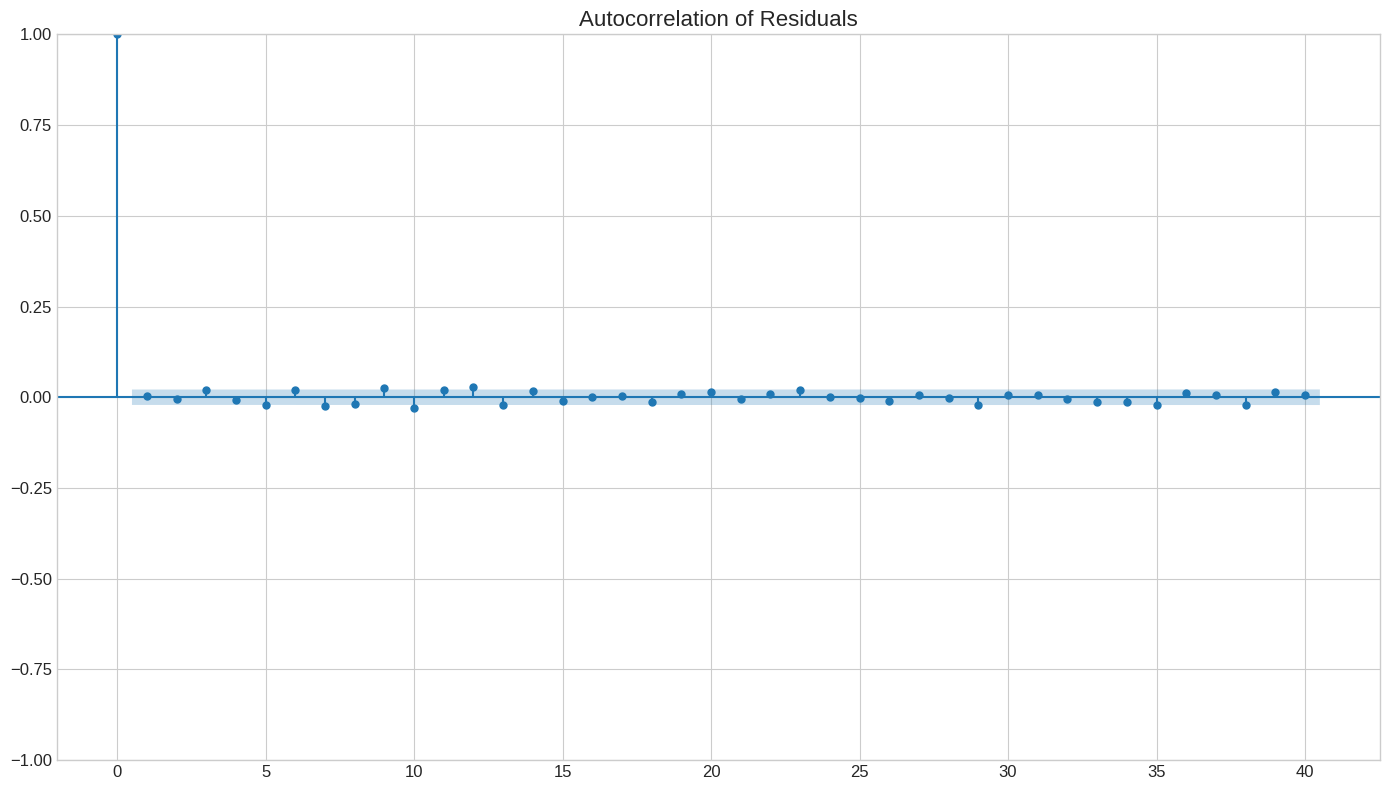


8. Volatility Analysis:


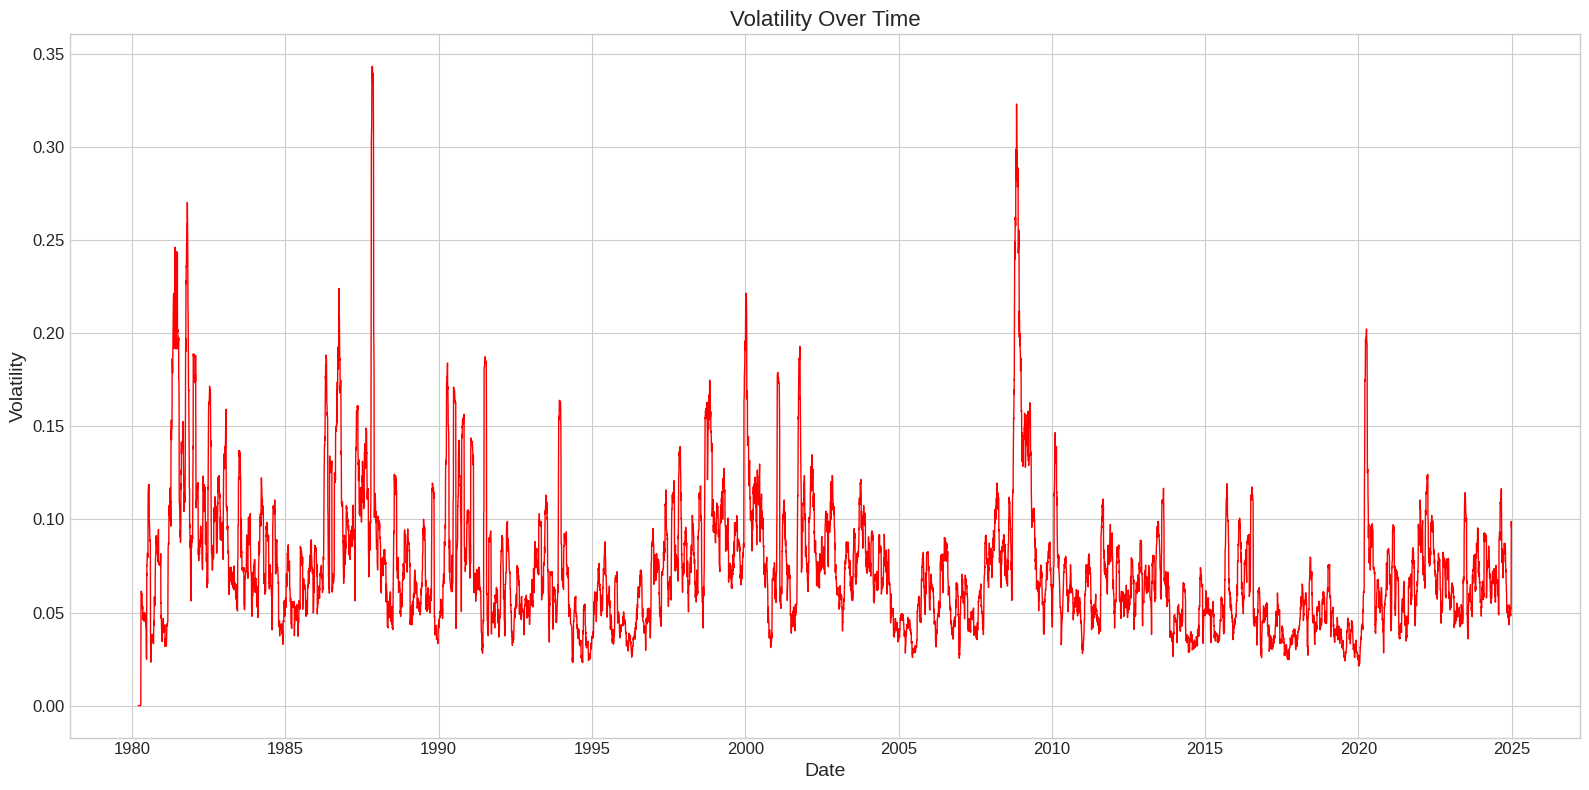


Correlation between Close price and Volatility:
               Close  Volatility
Close       1.000000   -0.251007
Volatility -0.251007    1.000000

9. Summary of Findings:
1. The Close price time series is not stationary initially.
2. 1 differencing operation(s) were applied to achieve stationarity.
3. ARIMA(1,1,1) model was fitted to the data.
4. Model performance metrics:
   - RMSE: 45.5950
   - MAE: 34.1870
   - MAPE: nan%
5. Check the residual plots to verify model assumptions.


In [ ]:
# 1. Visualize the original time series
print("\n1. Visualizing the Close price time series...")
plt.figure(figsize=(16, 8))
plt.plot(df_ts.index, df_ts['Close'], 'b-', linewidth=1)
plt.title('Close Price Time Series (1980-present)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('close_price_time_series.png')  # Save the plot
plt.show()

# 2. Check for stationarity
print("\n2. Checking for stationarity...")

def check_stationarity(series, title=''):
    """Test for stationarity using Augmented Dickey-Fuller test"""
    # Remove NaN values before testing
    series_clean = series.dropna()

    if len(series_clean) == 0:
        print("Series contains only NaN values after cleaning.")
        return False

    # Create a plot
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.plot(series_clean, 'b-', linewidth=1)
    plt.title(f'{title} Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)

    # Rolling statistics
    rolling_mean = series_clean.rolling(window=30).mean()
    rolling_std = series_clean.rolling(window=30).std()

    plt.subplot(212)
    plt.plot(series_clean, 'b-', linewidth=1, label='Original')
    plt.plot(rolling_mean, 'r-', linewidth=1, label='Rolling Mean (30-day)')
    plt.plot(rolling_std, 'g-', linewidth=1, label='Rolling Std (30-day)')
    plt.title('Rolling Statistics')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{title}_stationarity_check.png')  # Save the plot
    plt.show()

    # Perform ADF test
    result = adfuller(series_clean)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    is_stationary = result[1] <= 0.05
    print(f"The series is {'stationary' if is_stationary else 'non-stationary'}.")
    return is_stationary

is_stationary = check_stationarity(df_ts['Close'], 'Close Price')

# 3. If not stationary, apply differencing
if not is_stationary:
    print("\n3. Applying differencing...")
    df_ts['Close_diff'] = df_ts['Close'].diff()

    # Remove NaN values (first row after differencing)
    df_ts_clean = df_ts.dropna()

    # Check stationarity again
    print("\nAfter differencing:")
    is_stationary_after_diff = check_stationarity(df_ts_clean['Close_diff'], 'Differenced Close Price')

    # If still not stationary, try second order differencing
    if not is_stationary_after_diff:
        print("\nApplying second order differencing...")
        df_ts['Close_diff2'] = df_ts['Close_diff'].diff()
        df_ts_clean = df_ts.dropna()
        print("\nAfter second differencing:")
        is_stationary_after_diff2 = check_stationarity(df_ts_clean['Close_diff2'], 'Second Differenced Close Price')
        if is_stationary_after_diff2:
            series_to_use = df_ts_clean['Close_diff2']
            d_value = 2
        else:
            series_to_use = df_ts_clean['Close_diff']
            d_value = 1
    else:
        series_to_use = df_ts_clean['Close_diff']
        d_value = 1
else:
    series_to_use = df_ts['Close']
    d_value = 0
    df_ts_clean = df_ts

# 4. Seasonal decomposition (if data spans multiple years)
try:
    if len(df_ts) > 365:  # Only perform if we have at least a year of data
        print("\n4. Performing seasonal decomposition...")
        # For daily data, period=252 (trading days in a year)
        period = min(252, len(df_ts) // 4)

        # Seasonal decomposition
        decomposition = seasonal_decompose(
            df_ts['Close'].dropna(),
            model='additive',
            period=period
        )

        # Plot decomposition
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

        decomposition.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        ax1.grid(True)

        decomposition.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        ax2.grid(True)

        decomposition.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonality')
        ax3.grid(True)

        decomposition.resid.plot(ax=ax4)
        ax4.set_title('Residuals')
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig('seasonal_decomposition.png')  # Save the plot
        plt.show()
    else:
        print("Not enough data for seasonal decomposition.")
except Exception as e:
    print(f"Error in seasonal decomposition: {e}")

# 5. Plot ACF and PACF to determine ARIMA parameters
print("\n5. Plotting ACF and PACF...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Set maximum lag to be either 40 or 1/4 of the data length, whichever is smaller
max_lags = min(40, len(series_to_use) // 4)

plot_acf(series_to_use, lags=max_lags, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.grid(True)

plot_pacf(series_to_use, lags=max_lags, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.grid(True)

plt.tight_layout()
plt.savefig('acf_pacf.png')  # Save the plot
plt.show()

# 6. Fit ARIMA model
print("\n6. Fitting ARIMA model...")

# Prepare the data
data_to_use = df_ts['Close'].dropna()

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data_to_use) * 0.8)
train = data_to_use[:train_size]
test = data_to_use[train_size:]

print(f"Training data: {len(train)} observations")
print(f"Testing data: {len(test)} observations")

try:
    # Fit ARIMA model
    model = ARIMA(train, order=(p_value, d_value, q_value))
    fitted_model = model.fit()
    print("\nARIMA Model Summary:")
    print(fitted_model.summary())

    # Forecast
    forecast = fitted_model.forecast(steps=len(test))
    forecast_index = test.index

    # Plot forecast vs actual
    plt.figure(figsize=(16, 8))
    plt.plot(train.index, train, 'b-', label='Training Data')
    plt.plot(test.index, test, 'g-', label='Actual Test Data')
    plt.plot(forecast_index, forecast, 'r--', label='Forecasted Data')
    plt.title(f'ARIMA({p_value},{d_value},{q_value}) Forecast')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('arima_forecast.png')  # Save the plot
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - forecast) / test)) * 100

    print("\n7. Forecast Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

    # Residual analysis
    residuals = fitted_model.resid

    # Plot residuals
    plt.figure(figsize=(16, 10))

    plt.subplot(211)
    plt.plot(residuals, 'b-')
    plt.title('Residuals of ARIMA Model')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.grid(True)

    plt.subplot(212)
    plt.hist(residuals, bins=30)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('residuals.png')  # Save the plot
    plt.show()

    # Check residuals for autocorrelation
    plt.figure(figsize=(16, 8))
    plot_acf(residuals.dropna(), lags=min(40, len(residuals) // 4))
    plt.title('Autocorrelation of Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('residuals_acf.png')  # Save the plot
    plt.show()

    # 8. Optional: Volatility analysis using the Volatility column
    if 'Volatility' in df_ts.columns:
        print("\n8. Volatility Analysis:")
        plt.figure(figsize=(16, 8))
        plt.plot(df_ts.index, df_ts['Volatility'], 'r-', linewidth=1)
        plt.title('Volatility Over Time')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('volatility.png')  # Save the plot
        plt.show()

        # Correlation between Close price and Volatility
        corr = df_ts[['Close', 'Volatility']].corr()
        print("\nCorrelation between Close price and Volatility:")
        print(corr)

except Exception as e:
    print(f"Error in ARIMA modeling: {e}")
    import traceback
    traceback.print_exc()

# 9. Summary of findings
print("\n9. Summary of Findings:")
print(f"1. The Close price time series {'is' if is_stationary else 'is not'} stationary initially.")
print(f"2. {d_value} differencing operation(s) were applied to achieve stationarity.")
print(f"3. ARIMA({p_value},{d_value},{q_value}) model was fitted to the data.")
if 'mse' in locals():
    print(f"4. Model performance metrics:")
    print(f"   - RMSE: {rmse:.4f}")
    print(f"   - MAE: {mae:.4f}")
    print(f"   - MAPE: {mape:.4f}%")
print("5. Check the residual plots to verify model assumptions.")

In [ ]:
from google.colab import files
files.download('close_price_time_series.png')
files.download('seasonal_decomposition.png')
files.download('acf_pacf.png')
files.download('arima_forecast.png')
files.download('residuals.png')
files.download('residuals_acf.png')
files.download('volatility.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Gap,Gap_Percent,Volatility
Date,,,,,,,,,,
1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0,0.000000,NaN,0.0,0.0
1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0,0.004065,-3.291227,-100.0,0.0
1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0,0.000000,0.000000,0.0,0.0
1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0,0.000000,-3.304606,-100.0,0.0
1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0,0.024292,-3.304606,-100.0,0.0


# **Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np

def engineer_features(df):
    """
    Engineer features for stock price prediction based on EDA insights.

    Parameters:
    df (pandas.DataFrame): DataFrame with stock price data

    Returns:
    pandas.DataFrame: DataFrame with engineered features
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_feat = df.copy()

    # Ensure the 'Date' column is in datetime format (if not already)
    if 'Date' in df_feat.columns:
        df_feat['Date'] = pd.to_datetime(df_feat['Date'])
        df_feat.set_index('Date', inplace=True)

    # 1. Price-derived features
    df_feat['Daily_Range'] = df_feat['High'] - df_feat['Low']
    df_feat['Close_to_Open'] = df_feat['Close'] / df_feat['Open'] - 1
    df_feat['Close_to_High'] = df_feat['Close'] / df_feat['High'] - 1
    df_feat['Close_to_Low'] = df_feat['Close'] / df_feat['Low'] - 1

    # 2. Return-based features
    df_feat['Return_3d'] = df_feat['Close'].pct_change(3)
    df_feat['Return_5d'] = df_feat['Close'].pct_change(5)
    df_feat['Return_10d'] = df_feat['Close'].pct_change(10)
    df_feat['Cumulative_Return'] = (1 + df_feat['Daily_Return']).cumprod() - 1

    # 3. Volatility features
    df_feat['Volatility_5d'] = df_feat['Daily_Return'].rolling(window=5).std()
    df_feat['Volatility_10d'] = df_feat['Daily_Return'].rolling(window=10).std()
    df_feat['Volatility_Ratio'] = df_feat['Volatility_5d'] / df_feat['Volatility_10d']

    # 4. Volume-based features
    df_feat['Volume_Change'] = df_feat['Volume'].pct_change()
    df_feat['Volume_MA_5'] = df_feat['Volume'].rolling(window=5).mean()
    df_feat['Price_Volume_Corr_10d'] = df_feat['Close'].rolling(window=10).corr(df_feat['Volume'])

    # 5. Gap features
    df_feat['Gap_Direction'] = np.where(df_feat['Gap_Percent'] > 0, 1, 0)

    # 6. Technical indicators
    for window in [5, 10, 20, 50, 200]:
        df_feat[f'MA_{window}'] = df_feat['Close'].rolling(window=window).mean()

    # RSI (Relative Strength Index)
    delta = df_feat['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)  # Avoid division by zero
    df_feat['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df_feat['BB_MA_20'] = df_feat['Close'].rolling(window=20).mean()
    df_feat['BB_Std_20'] = df_feat['Close'].rolling(window=20).std()
    df_feat['BB_Upper'] = df_feat['BB_MA_20'] + (df_feat['BB_Std_20'] * 2)
    df_feat['BB_Lower'] = df_feat['BB_MA_20'] - (df_feat['BB_Std_20'] * 2)
    df_feat['BB_Width'] = (df_feat['BB_Upper'] - df_feat['BB_Lower']) / df_feat['BB_MA_20']
    df_feat['BB_%B'] = (df_feat['Close'] - df_feat['BB_Lower']) / (df_feat['BB_Upper'] - df_feat['BB_Lower'])

    # 7. Cyclical features
    df_feat['Day_of_Week'] = df_feat.index.dayofweek
    df_feat['Month'] = df_feat.index.month
    df_feat['Quarter'] = df_feat.index.quarter
    df_feat['Day_of_Week_sin'] = np.sin(2 * np.pi * df_feat['Day_of_Week'] / 5)
    df_feat['Day_of_Week_cos'] = np.cos(2 * np.pi * df_feat['Day_of_Week'] / 5)
    df_feat['Month_sin'] = np.sin(2 * np.pi * df_feat['Month'] / 12)
    df_feat['Month_cos'] = np.cos(2 * np.pi * df_feat['Month'] / 12)

    # 8. Lag features
    for lag in [1, 2, 3, 5, 10]:
        df_feat[f'Close_Lag_{lag}'] = df_feat['Close'].shift(lag)
        df_feat[f'Volume_Lag_{lag}'] = df_feat['Volume'].shift(lag)
        df_feat[f'Daily_Return_Lag_{lag}'] = df_feat['Daily_Return'].shift(lag)

    # 9. Target variable (predicting close price 5 days into the future)
    df_feat['Target_Price'] = df_feat['Close'].shift(-5)
    df_feat['Target_Return'] = df_feat['Target_Price'] / df_feat['Close'] - 1

    # Drop rows with NaN values (mainly from rolling calculations)
    df_feat = df_feat.dropna()

    # Replace infinite values with NaN and fill them
    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_feat.fillna(method='ffill', inplace=True)

    # Clip extreme values
    df_feat = df_feat.clip(lower=-1e6, upper=1e6)

    return df_feat

# Load your dataset into `df` (replace this with your actual data loading code)
# df = pd.read_csv('your_dataset.csv')

# Engineer features
df_features = engineer_features(df)

# Display the final dataset with engineered features
print(df_features.head())

            Adj Close     Close      High       Low      Open  Volume  \
Date                                                                    
1981-01-22   2.911611  4.172233  4.186281  4.172233  0.000000  8008.0   
1981-01-23   2.882201  4.130089  4.158185  4.130089  0.000000  1780.0   
1981-01-26   2.862594  4.101993  4.130089  4.101993  0.000000  3559.0   
1981-01-27   2.862594  4.101993  4.101993  4.101993  4.101993     0.0   
1981-01-29   2.852791  4.087945  4.130089  4.087945  0.000000   890.0   

            Daily_Return       Gap  Gap_Percent  Volatility  ...  \
Date                                                         ...   
1981-01-22      0.000000 -4.172233       -100.0    0.040387  ...   
1981-01-23     -0.010101 -4.172233       -100.0    0.042388  ...   
1981-01-26     -0.006803 -4.130089       -100.0    0.043343  ...   
1981-01-27      0.000000  0.000000          0.0    0.036065  ...   
1981-01-29     -0.003425 -4.101993       -100.0    0.031779  ...   

           

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Load your dataset with engineered features
# df_features = pd.read_csv('your_engineered_features.csv')

# Separate features and target
X = df_features.drop(columns=['Target_Price', 'Target_Return'])
y = df_features['Target_Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    direction_acc = accuracy_score((y_true.diff().shift(-1) > 0), (y_pred > y_true))
    print(f"{model_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {direction_acc:.4f}")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")

Random Forest Metrics:
RMSE: 2.4619
MAE: 1.4605
Directional Accuracy: 0.5119
XGBoost Metrics:
RMSE: 2.4965
MAE: 1.6028
Directional Accuracy: 0.5269


## **Corelation Matrix and Top Feature after Feature Engineering**

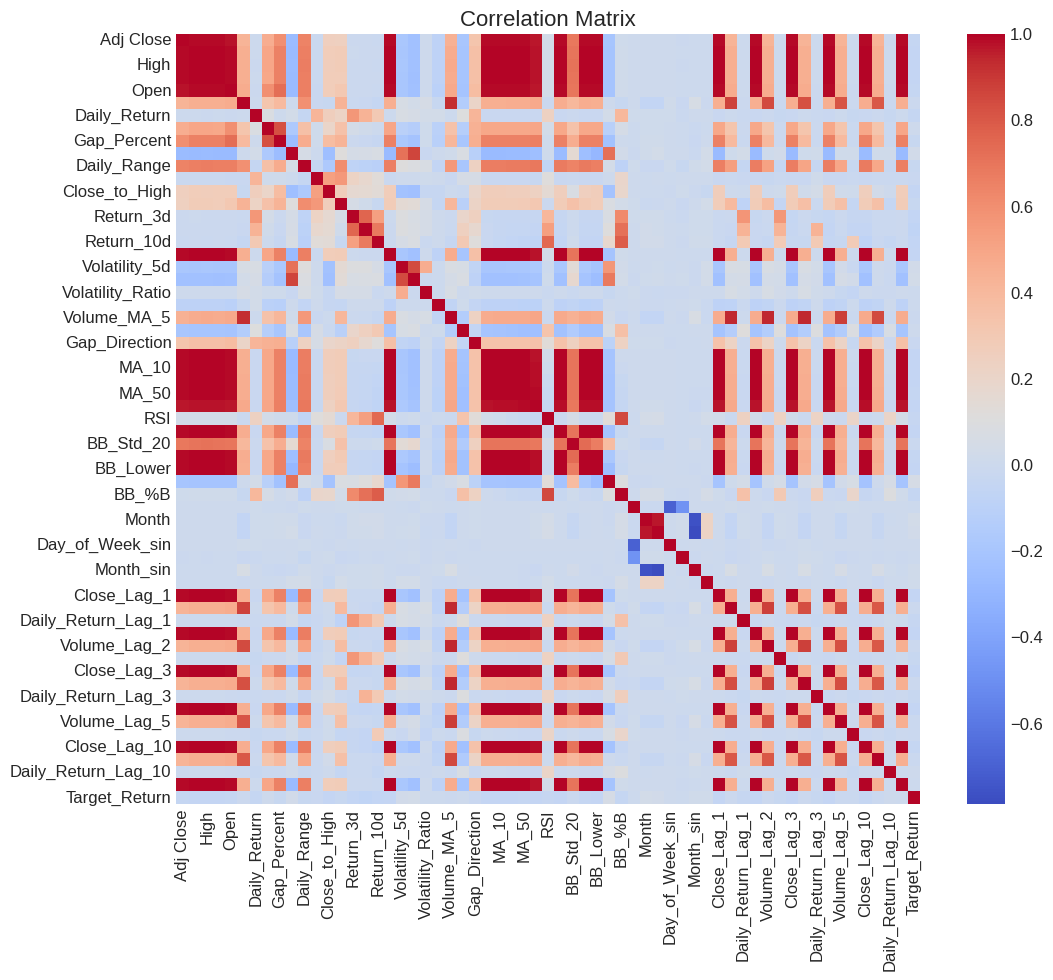

Top Features by Correlation:
['Target_Price', 'Close', 'Cumulative_Return', 'Low', 'High', 'Close_Lag_1', 'MA_5', 'Close_Lag_2', 'MA_10', 'Close_Lag_3', 'Close_Lag_5', 'MA_20', 'BB_MA_20', 'BB_Upper', 'Close_Lag_10', 'BB_Lower', 'MA_50', 'Adj Close', 'Open', 'MA_200']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Select top features based on correlation with target
top_features = corr_matrix['Target_Price'].abs().sort_values(ascending=False).head(20).index.tolist()
print("Top Features by Correlation:")
print(top_features)

In [ ]:
df_features.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Gap,Gap_Percent,Volatility,...,Volume_Lag_3,Daily_Return_Lag_3,Close_Lag_5,Volume_Lag_5,Daily_Return_Lag_5,Close_Lag_10,Volume_Lag_10,Daily_Return_Lag_10,Target_Price,Target_Return
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-22,2.911611,4.172233,4.186281,4.172233,0.000000,8008.0,0.000000,-4.172233,-100.0,0.040387,...,1780.0,0.000000,4.101993,8898.0,0.000000,4.158185,4449.0,0.003390,4.087945,-0.020202
1981-01-23,2.882201,4.130089,4.158185,4.130089,0.000000,1780.0,-0.010101,-4.172233,-100.0,0.042388,...,6229.0,0.003425,4.101993,4449.0,0.000000,4.144137,1780.0,-0.003378,4.158185,0.006803
1981-01-26,2.862594,4.101993,4.130089,4.101993,0.000000,3559.0,-0.006803,-4.130089,-100.0,0.043343,...,4449.0,0.013652,4.101993,1780.0,0.000000,4.130089,1780.0,-0.003390,4.200329,0.023973
1981-01-27,2.862594,4.101993,4.101993,4.101993,4.101993,0.0,0.000000,0.000000,0.0,0.036065,...,8008.0,0.000000,4.116041,6229.0,0.003425,4.073897,1780.0,-0.013605,4.200329,0.023973
1981-01-29,2.852791,4.087945,4.130089,4.087945,0.000000,890.0,-0.003425,-4.101993,-100.0,0.031779,...,3559.0,-0.006803,4.172233,8008.0,0.000000,4.101993,8898.0,0.000000,4.158185,0.017182


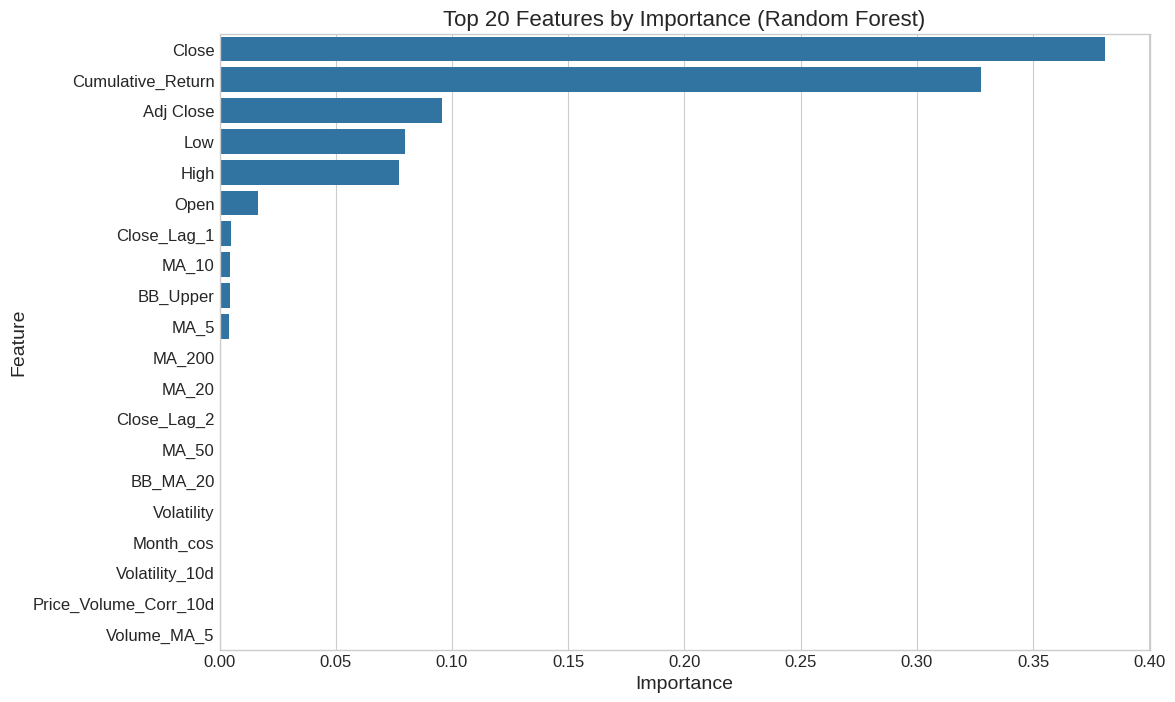

Top Features by Random Forest Importance:
['Close', 'Cumulative_Return', 'Adj Close', 'Low', 'High', 'Open', 'Close_Lag_1', 'MA_10', 'BB_Upper', 'MA_5', 'MA_200', 'MA_20', 'Close_Lag_2', 'MA_50', 'BB_MA_20', 'Volatility', 'Month_cos', 'Volatility_10d', 'Price_Volume_Corr_10d', 'Volume_MA_5']


In [ ]:
# Get feature importances from Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features by Importance (Random Forest)')
plt.show()

# Select top features
top_features_rf = feature_importances.head(20)['Feature'].tolist()
print("Top Features by Random Forest Importance:")
print(top_features_rf)

In [ ]:
# Select top 10 features
X_top10 = X[top_features_rf[:10]]  # Select the top 10 most important features

# Split data into training and testing sets
X_train_top10, X_test_top10, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42)

# Retrain Random Forest
rf_model_top10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top10.fit(X_train_top10, y_train)

# Retrain XGBoost
xgb_model_top10 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_top10.fit(X_train_top10, y_train)

# Make predictions
rf_pred_top10 = rf_model_top10.predict(X_test_top10)
xgb_pred_top10 = xgb_model_top10.predict(X_test_top10)

# Evaluate models
evaluate_model(y_test, rf_pred_top10, "Random Forest (Top 10 Features)")
evaluate_model(y_test, xgb_pred_top10, "XGBoost (Top 10 Features)")


Random Forest (Top 10 Features) Metrics:
RMSE: 2.9175
MAE: 1.7363
Directional Accuracy: 0.5114
XGBoost (Top 10 Features) Metrics:
RMSE: 3.0709
MAE: 1.8883
Directional Accuracy: 0.5250


In [ ]:
top_features_rf

AttributeError: 'list' object has no attribute 'head'

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters for Random Forest:", grid_search.best_params_)

# Train with best parameters
best_rf_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluate
rf_pred_tuned = best_rf_model.predict(X_test)
evaluate_model(y_test, rf_pred_tuned, "Tuned Random Forest")

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest Metrics:
RMSE: 2.4737
MAE: 1.4637
Directional Accuracy: 0.5162


# **Training Models**

## **LSTM**

Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - loss: 5.8926e-04 - val_loss: 0.0015
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 1.8663e-04 - val_loss: 0.0018
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 2.5683e-04 - val_loss: 7.8180e-04
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 1.8045e-04 - val_loss: 7.1669e-04
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 1.4113e-04 - val_loss: 0.0010
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 1.4266e-04 - val_loss: 9.8167e-04
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 1.3960e-04 - val_loss: 0.0013
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 1.3906e-04 - val_loss: 9.1237e-04
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 1.6186e-04 - val_loss: 0.0019
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 1.3712e-04 - val_loss: 8.7201e-04
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - lo

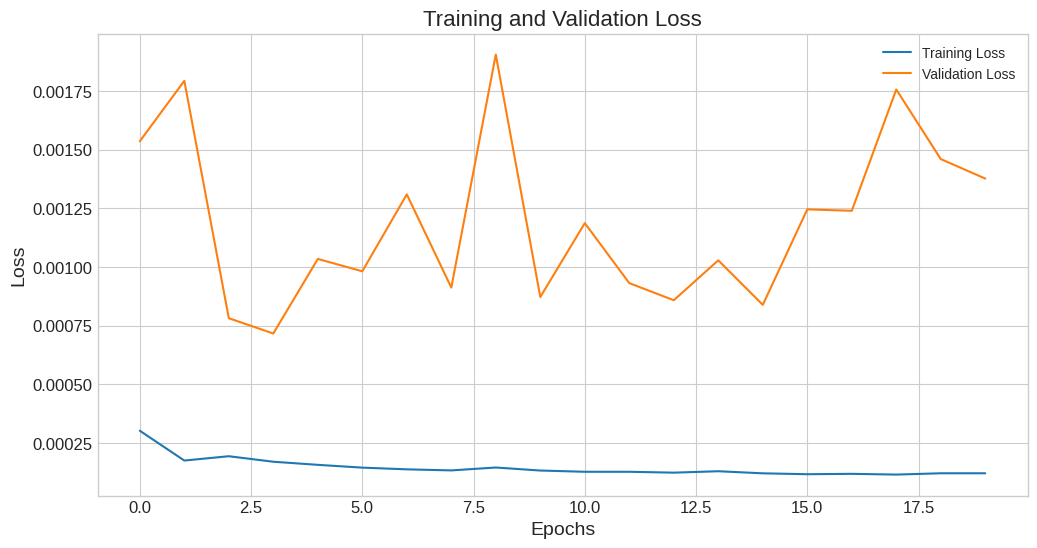

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
LSTM (Top 20 Features) Metrics:
RMSE: 9.3087
MAE: 6.1716


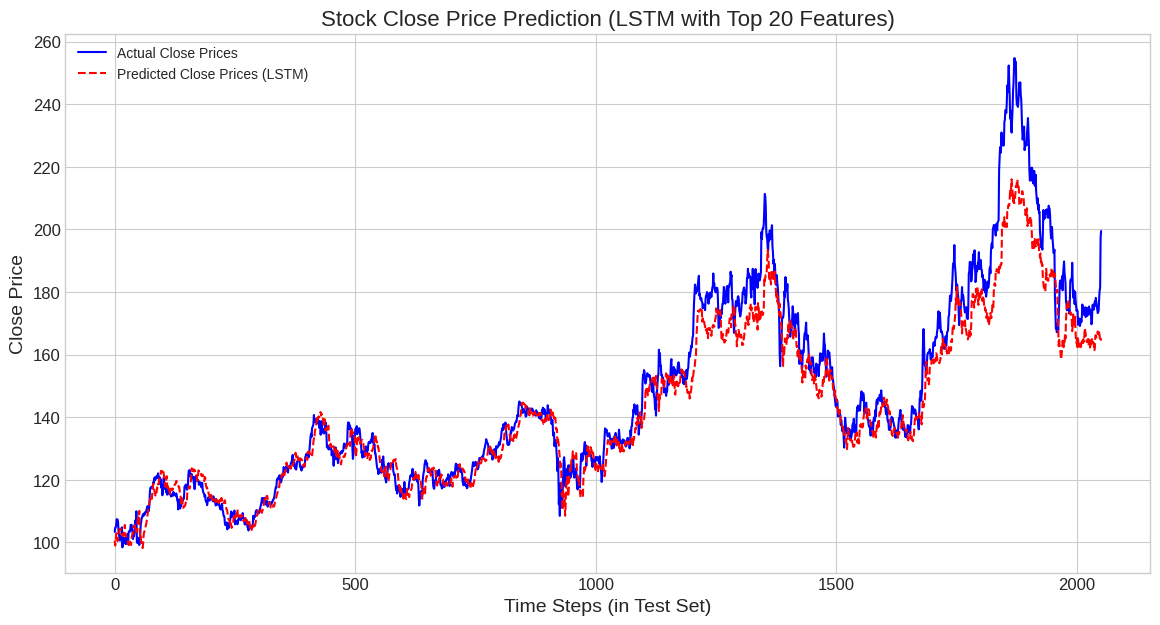

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Use only the Top 20 Features ---
X_top20 = df_features[top_features_rf]  # Ensure df_features contains the required features
y = df_features['Target_Price']

# --- Feature Scaling ---
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_top20)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# --- Create Sequences for LSTM ---
def create_sequences(data, labels, sequence_length):
    sequences, seq_labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        seq_labels.append(labels[i + sequence_length])
    return np.array(sequences), np.array(seq_labels)

sequence_length = 60  # Using past 60 days to predict next value
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# --- Build the LSTM Model ---
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    LSTM(units=50),
    Dense(units=1)
])

# --- Compile and Train the LSTM Model ---
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# --- Plot Training and Validation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Make Predictions ---
y_pred_scaled = model.predict(X_test)

# --- Inverse Transform Predictions to Original Scale ---
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# --- Evaluate the Model ---
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

evaluate_model(y_test_original, y_pred, "LSTM (Top 20 Features)")

# --- Plot Actual vs. Predicted Prices ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Close Prices', color='blue')
plt.plot(y_pred, label='Predicted Close Prices (LSTM)', color='red', linestyle='dashed')
plt.title('Stock Close Price Prediction (LSTM with Top 20 Features)')
plt.xlabel('Time Steps (in Test Set)')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


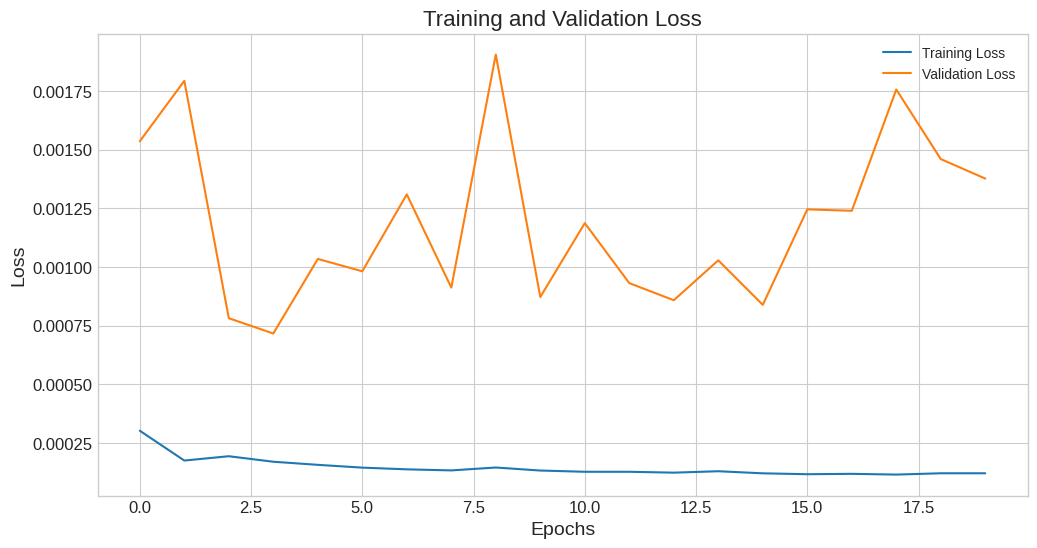

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png', dpi=300)  # Save as PNG
plt.show()


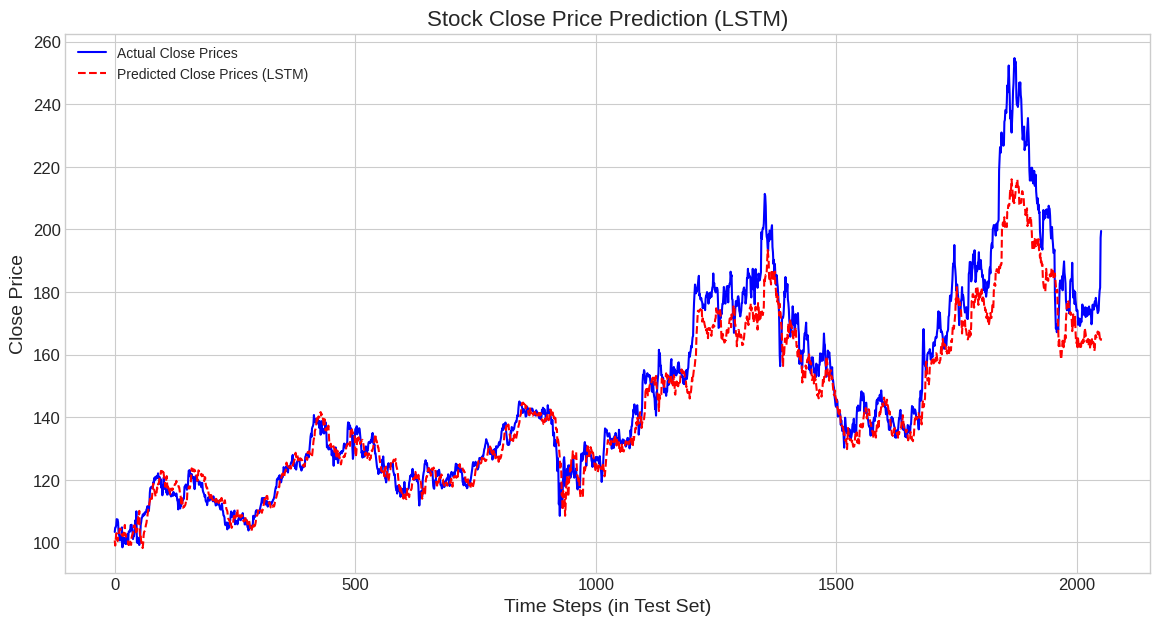

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Close Prices', color='blue')
plt.plot(y_pred, label='Predicted Close Prices (LSTM)', color='red', linestyle='dashed')
plt.title('Stock Close Price Prediction (LSTM)')
plt.xlabel('Time Steps (in Test Set)')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.savefig('lstm_stock_prediction.png', dpi=300)  # Save as PNG
plt.show()


In [ ]:
from google.colab import files
files.download('training_loss.png')
files.download('lstm_stock_prediction.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Select the Top 10 Features
X_top10 = df_features[top_features_rf[:10]]  # Select the top 10 most important features
y = df_features['Target_Price']

# Split data into training and testing sets
X_train_top10, X_test_top10, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42)

# Train the Random Forest Model
rf_model_top10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top10.fit(X_train_top10, y_train)

# Make Predictions
rf_pred_top10 = rf_model_top10.predict(X_test_top10)

# Evaluate the Model
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {model_name} Performance Metrics:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

evaluate_model(y_test, rf_pred_top10, "Random Forest (Top 10 Features)")



📊 Random Forest (Top 10 Features) Performance Metrics:
✅ RMSE: 2.9175
✅ MAE: 1.7363
✅ R² Score: 0.9968


## **XGBoost**

In [ ]:
from xgboost import XGBRegressor

# Train the XGBoost Model
xgb_model_top10 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_top10.fit(X_train_top10, y_train)

# Make Predictions
xgb_pred_top10 = xgb_model_top10.predict(X_test_top10)

# Evaluate the Model
evaluate_model(y_test, xgb_pred_top10, "XGBoost (Top 10 Features)")



📊 XGBoost (Top 10 Features) Performance Metrics:
✅ RMSE: 3.0709
✅ MAE: 1.8883
✅ R² Score: 0.9965


## **Improved LSTM**

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - loss: 0.0637 - val_loss: 0.3367
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - loss: 0.0646 - val_loss: 0.3367
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - loss: 0.0626 - val_loss: 0.3367
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - loss: 0.0641 - val_loss: 0.3367
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.0646 - val_loss: 0.3367
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - loss: 0.0635 - val_loss: 0.3367
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.0654 - val_loss: 0.3367
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - loss: 0.0652 - val_loss: 0.3367
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 299ms/step - loss: 0.0657 - val_loss: 0.3367
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - loss: 0.0639 - val_loss: 0.3367
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - loss: 0.0643 - val_loss: 0.3367
Epoch 12/50
129/129

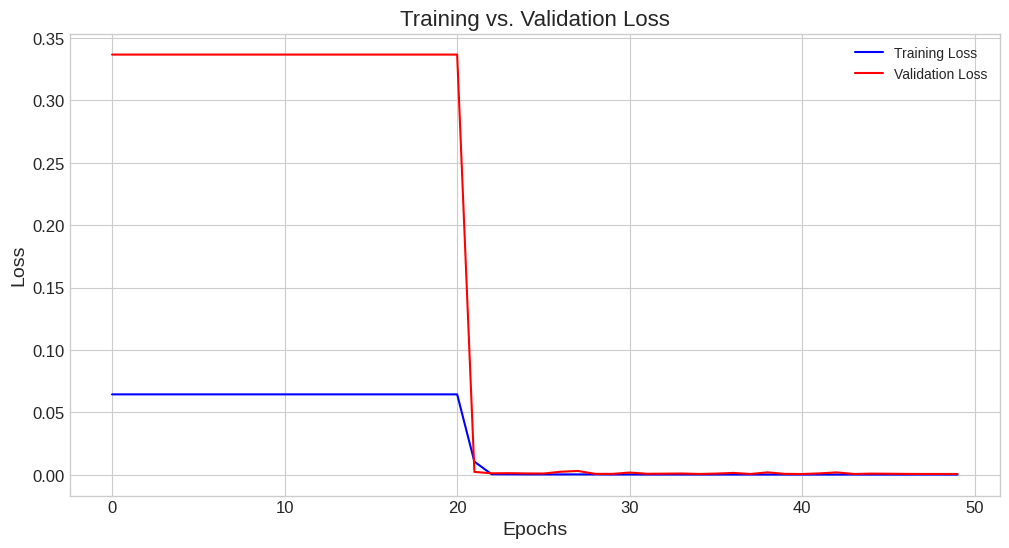

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

📊 Optimized LSTM Model (Top 10 Features) Performance Metrics:
✅ RMSE: 6.6929
✅ MAE: 4.5879
✅ R² Score: 0.9541


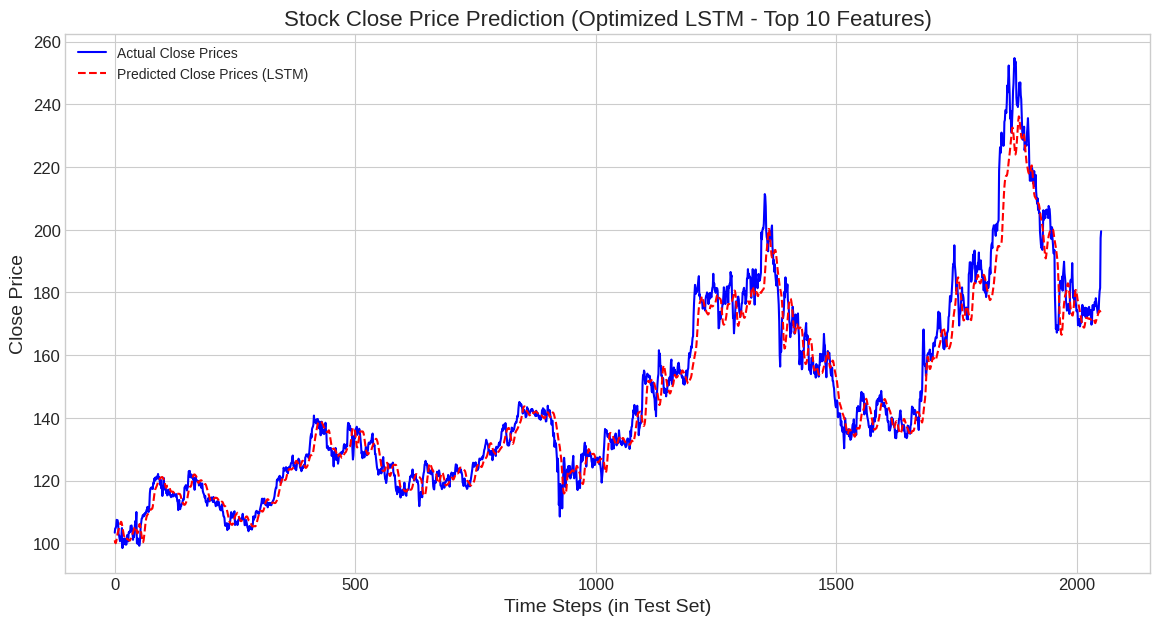

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Use only the Top 10 Features ---
X_top10 = df_features[top_features_rf[:10]]  # Select top 10 features
y = df_features['Target_Price']

# --- Feature Scaling ---
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_top10)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# --- Create Sequences for LSTM ---
def create_sequences(data, labels, sequence_length):
    sequences, seq_labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        seq_labels.append(labels[i + sequence_length])
    return np.array(sequences), np.array(seq_labels)

sequence_length = 60  # Using past 60 days to predict next value
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# --- Build the Optimized LSTM Model ---
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=1, activation='relu')  # ReLU activation for better performance
])

# --- Compile and Train the Model ---
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# --- Plot Training & Validation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Make Predictions ---
y_pred_scaled = model.predict(X_test)

# --- Inverse Transform Predictions to Original Scale ---
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# --- Evaluate the Model ---
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {model_name} Performance Metrics:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

evaluate_model(y_test_original, y_pred, "Optimized LSTM Model (Top 10 Features)")

# --- Plot Actual vs. Predicted Prices ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Close Prices', color='blue')
plt.plot(y_pred, label='Predicted Close Prices (LSTM)', color='red', linestyle='dashed')
plt.title('Stock Close Price Prediction (Optimized LSTM - Top 10 Features)')
plt.xlabel('Time Steps (in Test Set)')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


## Further Improved **LSTM**

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 100s 306ms/step - loss: 0.0028 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 79s 307ms/step - loss: 5.9588e-04 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - loss: 5.2740e-04 - val_loss: 8.7791e-04 - learning_rate: 0.0010
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 79s 299ms/step - loss: 4.4560e-04 - val_loss: 8.7147e-04 - learning_rate: 0.0010
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - loss: 4.1651e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - loss: 3.8625e-04 - val_loss: 9.9414e-04 - learning_rate: 0.0010
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - loss: 3.3542e-04 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 137s 300ms/step - loss: 3.4583e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step

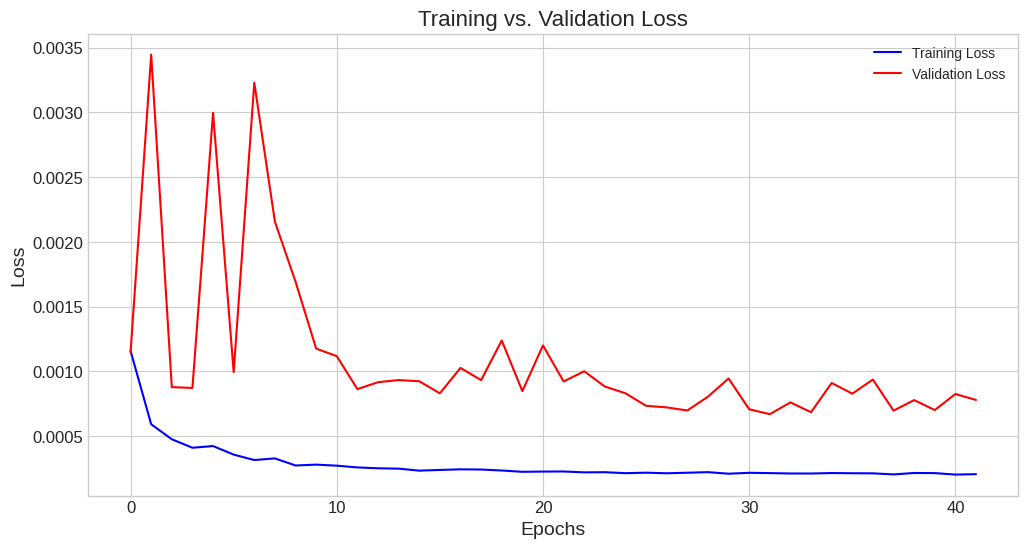


✅ Model saved as 'improved_lstm_model.keras'

🔍 Loaded Model Name: sequential_1
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step

📊 Improved LSTM Model Performance Metrics:
✅ RMSE: 6.4892
✅ MAE: 4.4041
✅ R² Score: 0.9568


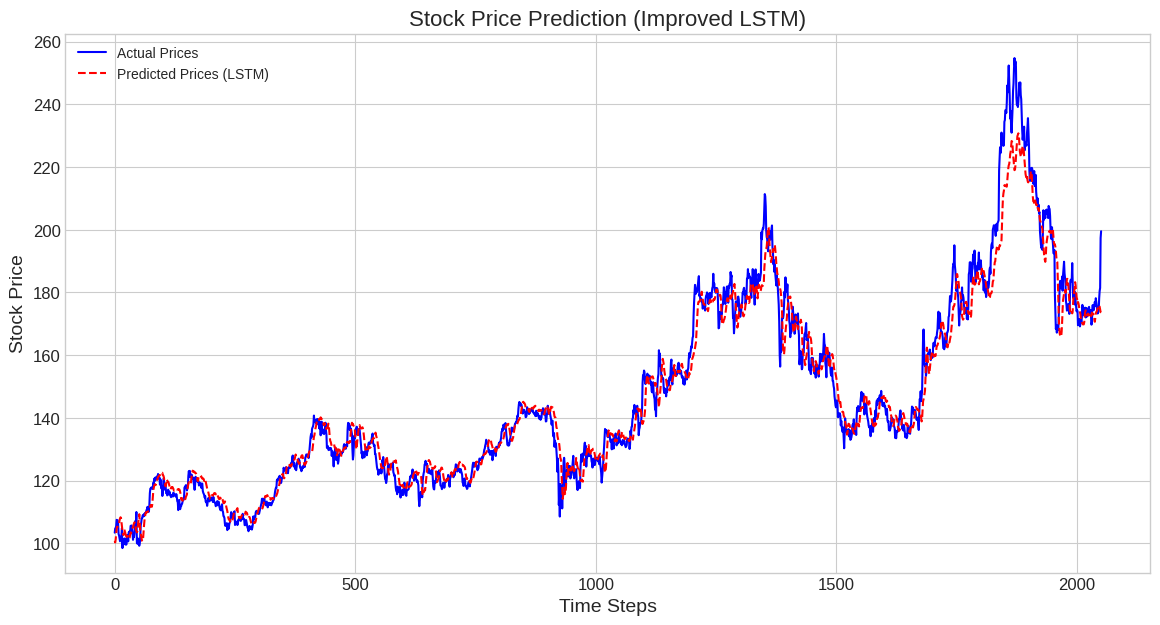

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Feature Scaling ---
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_top10)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# --- Create Sequences ---
def create_sequences(data, labels, sequence_length):
    sequences, seq_labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        seq_labels.append(labels[i + sequence_length])
    return np.array(sequences), np.array(seq_labels)

sequence_length = 60  # Experiment with 30, 60, 90
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length)

# --- Split Data ---
train_size = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# --- Build the Improved LSTM Model ---
model = Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]))),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True),  # Additional LSTM Layer
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(units=1, activation='relu')  # ReLU for better performance
])

# --- Compile Model ---
model.compile(optimizer='adam', loss='mean_squared_error')

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# --- Train the Model ---
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

# --- Plot Training vs. Validation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Save Model in New Keras Format ---
model.save("improved_lstm_model.keras")  # ✅ Fix: Using Keras format instead of HDF5

print("\n✅ Model saved as 'improved_lstm_model.keras'")

# --- Load the Model Safely ---
loaded_model = load_model("improved_lstm_model.keras")

# ✅ Fix: Recompile the model after loading to avoid the 'compiled metrics' warning
loaded_model.compile(optimizer='adam', loss='mean_squared_error')

print("\n🔍 Loaded Model Name:", loaded_model.name)

# --- Make Predictions ---
y_pred_scaled = loaded_model.predict(X_test)

# --- Inverse Transform Predictions ---
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# --- Evaluate the Model ---
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {model_name} Performance Metrics:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

evaluate_model(y_test_original, y_pred, "Improved LSTM Model")

# --- Plot Actual vs. Predicted Prices ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices (LSTM)', color='red', linestyle='dashed')
plt.title('Stock Price Prediction (Improved LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Save only the top 10 features dataset
X_top10.to_csv("X_top10_features.csv", index=False)

# Download the file
from google.colab import files
files.download("X_top10_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('improved_lstm_model.keras')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Save the scalers
import pickle
with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

# Download files
files.download("improved_lstm_model.keras")
files.download("scaler_X.pkl")
files.download("scaler_y.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>